# Прогнозирование стоимости покупки подержанного автомобиля

**Содержание:**  
1. [Загрузка данных и общая информация](#section_1)  
 1.1. [Импорт библиотек](#section_1_1)  
 1.2. [Загрузка данных](#section_1_2)  
 1.3. [Общая информация](#section_1_3)  
    
    
2. [Предобработка данных](#section_2)  
 2.1. [Предобработка текстовых признаков](#section_2_1)  
 2.2. [Предобработка числовых признаков](#section_2_2)  

3. [Исследовательский анализ данных](#section_3)  
 3.1. [Распределения значений признаков](#section_3_1)  
 3.2. [Корреляция признаков](#section_3_2) 

4. [Обучение и оценка модели](#section_4)  
 4.1. [Подготовка данных](#section_4_1)  
 4.2. [Обучение модели](#section_4_2)  
 4.3. [Оценка значимости признаков](#section_4_3)  
 4.4. [Предсказание на тестовой выборке](#section_4_4)  


5. [Общий вывод](#section_5)  

**Заказчик исследования:** сеть отелей.  
**Цель исследования:** разработка и обучение ML-модели прогнозирования стоимости подержанного автомобиля и определение признаков, оказывающих наибольшее влияние на цену.

**Исходные данные:**  
Исходные данные представлены в датасетах:
- train.csv — обучающая выборка;
- test.csv — тестовая выборка.

В датасетах содержатся следующие признаки:  
- 'year' - год производства;
- 'condition' - состояние по шкале (1-5);
- 'make' - производитель;
- 'odometer' - пробег в милях;
- 'model' - модель;
- 'color' - цвет кузова;
- 'trim' - модификация;
- 'interior' - цвет интерьера;
- 'body' - тип кузова;
- 'seller' - продавец;
- 'transmission' - тип КПП;
- 'sellingprice' - стоимость продажи;
- 'vin' - идентификатор (вин);
- 'saledate' - дата продажи;
- 'state' - штат регистрации.

Метрика оценки - MAPE.

Тестовая выборка предназначена для проверки результатов в Kaggle.

## Загрузка данных и общая информация
<a id="section_1"></a>

### Импорт библиотек
<a id="section_1_1"></a>

In [1]:
import dateparser
import math
import re
import timeit

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import swifter

from catboost import CatBoostRegressor
from optuna.distributions import FloatDistribution as floatd
from optuna.distributions import IntDistribution as intd
from optuna.integration import OptunaSearchCV
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

### Загрузка данных
<a id="section_1_2"></a>

In [2]:
def read_table(linc):
    '''функция загрузки таблиц по ссылке'''
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = linc

    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    # Загружаем файл и сохраняем его
    download_response = requests.get(download_url)
    pd.read_csv(download_url) 
    return pd.read_csv(download_url)

In [3]:
try:
    df_train = read_table('https://disk.yandex.ru/d/fiWbGsGFgvGtog')
except:
    df_train = pd.read_csv('train.csv')
    
try:
    df_test = read_table('https://disk.yandex.ru/d/4R_ZeJtz7Ooa5Q')
except:
    df_test = pd.read_csv('test.csv')

### Общая информация
<a id="section_1_3"></a>

Функция вывода общей информации:

In [4]:
def inf(df_tmp):
    '''функция получения общей информации'''
    print('Размер датафрейма:')
    print(df_tmp.shape)
    print('_' * 50)
    print()
    print('Общая информация о датафрейме:')
    print(df_tmp.info(memory_usage='deep'))
    print('_' * 50)
    print()
    print('Несколько строк датафрейма:')
    display(df_tmp.sample(random_state=0, n=5))
    print('_' * 50)
    print()
    print('Количество полных дубликатов:')
    print(df_tmp.duplicated().sum())
    print('_' * 50)
    print()
    print('Количество дубликатов идентификатора:')
    print(df_tmp['vin'].duplicated().sum())
    print('_' * 50)
    print()
    if 'vin' in df_tmp.columns:
        print()
        print('Количество дубликатов без учета поля идентификатора:')
        print(df_tmp.drop(columns=['vin']).duplicated().sum())
        print('_' * 50)
    print()
    print('Описательная статистика строковых значений:')
    display(df_tmp.describe(include=['object']).T)
    print('_' * 50)
    print()
    print('Описательная статистика числовых значений:')
    display(df_tmp.describe().T)
    print('_' * 50)
    print()
    print('Количество пропусков:')
    print(df_tmp.isna().sum())
    print()
    print('Количество пропусков в процентах:')
    print(df_tmp.isna().mean()*100)

In [5]:
def intermediate_information(df):
    display(df.sample(random_state=0, n=5))
    print(df.info(memory_usage='deep'))

Общая информация по обучающим данным:

In [6]:
inf(df_train)

Размер датафрейма:
(440236, 15)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
29256,2014,BMW,3 Series,328i xDrive SULEV,Sedan,automatic,wba3b5g54ens10954,oh,4.2,2223.0,—,black,bmw na manheim new jersey,37500,Tue Jan 27 2015 06:00:00 GMT-0800 (PST)
107420,2013,Lexus,CT 200h,Base,hatchback,automatic,jthkd5bhxd2154964,ca,2.5,12002.0,—,tan,high bid trading co inc,18000,Wed Jun 03 2015 05:15:00 GMT-0700 (PDT)
417721,2003,Mercedes-Benz,C-Class,C240 4MATIC,Sedan,automatic,wdbrf81j43f401613,nc,3.0,151715.0,black,black,credit acceptance corp/vrs/southfield,2400,Mon Jan 12 2015 00:00:00 GMT-0800 (PST)
143756,2013,Hyundai,Sonata,GLS,Sedan,automatic,5npeb4ac9dh683308,mi,4.6,51606.0,white,beige,dtg operations inc,11300,Thu Feb 12 2015 01:30:00 GMT-0800 (PST)
266550,2004,Ford,Focus,ZTS,Sedan,automatic,1fafp38z04w200363,tx,2.0,117489.0,gray,—,unlimited auto finance group,1200,Tue May 05 2015 02:15:00 GMT-0700 (PDT)


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов идентификатора:
0
__________________________________________________


Количество дубликатов без учета поля идентификатора:
0
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
make,432193,92,Ford,73708
model,432113,959,Altima,15454
trim,431899,1922,Base,43853
body,429843,85,Sedan,157639
transmission,388775,2,automatic,375061
vin,440236,440236,2fmdk3jc4bba41556,1
state,440236,38,fl,65618
color,439650,20,black,87115
interior,439650,17,black,192442
seller,440236,13025,nissan-infiniti lt,15823


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
year,440236.0,2010.040101,3.977945,1982.0,2007.0,2012.0,2013.0,2015.0
condition,430831.0,3.425077,0.949973,1.0,2.7,3.6,4.2,5.0
odometer,440167.0,68344.421604,53542.203908,1.0,28258.0,52098.0,99272.0,999999.0
sellingprice,440236.0,13592.209588,9751.479098,1.0,6900.0,12100.0,18200.0,230000.0


__________________________________________________

Количество пропусков:
year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

Количество пропусков в процентах:
year             0.000000
make             1.826975
model            1.845147
trim             1.893757
body             2.360779
transmission    11.689412
vin              0.000000
state            0.000000
condition        2.136354
odometer         0.015673
color            0.133110
interior         0.133110
seller           0.000000
sellingprice     0.000000
saledate         0.000000
dtype: float64


Общая информация по тестовым данным:

In [7]:
inf(df_test)

Размер датафрейма:
(110060, 14)
__________________________________________________

Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 80.6 MB
None
__

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
30257,2013,Nissan,Altima,2.5 S,Coupe,automatic,1n4al2ep4dc153469,ga,3.7,56097.0,gray,black,the hertz corporation,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
90584,2014,Nissan,NV Cargo,2500 S,Van,automatic,1n6bf0lyxen100980,pa,3.5,38828.0,white,gray,exceptional motorcars ltd,Wed Feb 18 2015 01:30:00 GMT-0800 (PST)
37119,2015,Ford,Taurus,Limited,sedan,automatic,1fahp2f81fg104879,ne,4.0,17603.0,gray,black,enterprise vehicle exchange/davenport,Thu Jun 04 2015 03:30:00 GMT-0700 (PDT)
86069,2010,Chevrolet,Silverado 1500,LT,Crew Cab,automatic,3gcrcse06ag218007,tx,2.9,111333.0,black,brown,alamo city autoplex,Wed Feb 18 2015 02:00:00 GMT-0800 (PST)
37324,2005,Ford,Freestyle,SE,Wagon,automatic,1fmdk01165ga81292,nj,2.5,118248.0,gray,gray,wells fargo dealer services,Wed Mar 04 2015 01:30:00 GMT-0800 (PST)


__________________________________________________

Количество полных дубликатов:
0
__________________________________________________

Количество дубликатов идентификатора:
0
__________________________________________________


Количество дубликатов без учета поля идентификатора:
0
__________________________________________________

Описательная статистика строковых значений:


,count,unique,top,freq
make,107999,85,Ford,18384
model,107981,824,Altima,3736
trim,107946,1496,Base,11007
body,107466,77,Sedan,39255
transmission,97048,2,automatic,93585
vin,110060,110060,1g6dp567450124779,1
state,110060,38,fl,16295
color,109902,20,black,22006
interior,109902,17,black,48176
seller,110060,7623,"ford motor credit company,llc",3858


__________________________________________________

Описательная статистика числовых значений:


,count,mean,std,min,25%,50%,75%,max
year,110060.0,2010.059904,3.960432,1982.0,2007.0,2012.0,2013.0,2015.0
condition,107681.0,3.423206,0.951323,1.0,2.7,3.6,4.2,5.0
odometer,110041.0,68075.693541,53523.551837,1.0,28314.0,51922.0,98854.0,999999.0


__________________________________________________

Количество пропусков:
year                0
make             2061
model            2079
trim             2114
body             2594
transmission    13012
vin                 0
state               0
condition        2379
odometer           19
color             158
interior          158
seller              0
saledate            0
dtype: int64

Количество пропусков в процентах:
year             0.000000
make             1.872615
model            1.888970
trim             1.920770
body             2.356896
transmission    11.822642
vin              0.000000
state            0.000000
condition        2.161548
odometer         0.017263
color            0.143558
interior         0.143558
seller           0.000000
saledate         0.000000
dtype: float64


**Вывод:**
1. В обучающей выборке 440236 строк и 15 признаков, в тестовой выборке 110060 строк и 14 признаков.
2. В полях make, model, trim, body, transmission, condition, odometer, color, interior присутствуют пропущенные значения.
2. Следующие признаки имеют тип int64:  
 - year;  
 - sellingprice.
 
 Следующие признаки имеют тип object:   
  - make;
  - model; 
  - trim; 
  - body; 
  - transmission; 
  - vin; 
  - state; 
  - color; 
  - interior; 
  - seller; 
  - saledate.   

 Следующие признаки имеют тип float64:  
  - condition;
  - odometer.

## Предобработка данных
<a id="section_2"></a>

Задаем значение random_state:

In [8]:
RS = 42

### Предобработка текстовых признаков
<a id="section_2_1"></a>

Удаляем из тестовой выборки наблюдения, в которых отсутствуют данные по производителю:

In [9]:
df_train = df_train.dropna(subset=['make'])

Создаем список текстовых признаков:

In [10]:
text_list = ['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller']

Переводим значения текстовых признаков в нижний регистр и заменяем пропуски на "unknown":

In [11]:
def text_nan(df):
    df[text_list] = df[text_list].fillna('unknown')    # заменяем пропуски на unknown
    for i in text_list:                                # проходим по списку текстовых признаков
        df[i] = df[i].map(str.lower)                   # переводим в нижний регистр
    # заменяем текстовые значения "nan" и "—" на unknown
    df[text_list] = df[text_list].replace({'nan' : 'unknown', '—' : 'unknown'})
    return df

In [12]:
df_train = text_nan(df_train)
df_test = text_nan(df_test)

Выводим уникальные значения признака "make" (производитель) обучающей выборки:

In [13]:
df_train['make'].unique()

array(['ford', 'nissan', 'hummer', 'lincoln', 'pontiac', 'hyundai',
       'buick', 'chevrolet', 'honda', 'acura', 'cadillac', 'gmc', 'saab',
       'dodge', 'mercedes-benz', 'toyota', 'volkswagen', 'bmw',
       'infiniti', 'chrysler', 'kia', 'jaguar', 'subaru', 'jeep', 'lexus',
       'mercedes', 'scion', 'fiat', 'suzuki', 'mazda', 'volvo', 'audi',
       'mini', 'isuzu', 'mitsubishi', 'smart', 'porsche', 'land rover',
       'saturn', 'ram', 'oldsmobile', 'mercury', 'bentley', 'fisker',
       'maserati', 'tesla', 'landrover', 'vw', 'gmc truck', 'rolls-royce',
       'ferrari', 'plymouth', 'lamborghini', 'geo', 'ford truck',
       'aston martin', 'daewoo', 'mercedes-b', 'dodge tk', 'mazda tk',
       'dot', 'airstream'], dtype=object)

Присутствуют неявные дубликаты значений признака "make" (производитель). Избавляемся от них:

In [14]:
def change_make(df):
    list_make = {'^ford.*':'ford',
             '^gmc.*':'gmc',
             '^dodge.*':'dodge',
             '^mercedes.*':'mercedes',
             '^vw.*':'volkswagen',
             '^mazda.*':'mazda',
             '^land.*':'land rover'}
    df['make'] = df['make'].replace(list_make, regex=True)          # Замена в датафрейме
    return df

In [15]:
df_train = change_make(df_train)
df_test = change_make(df_test)

Заполняем пропуски признака "make" (производитель) наиболее часто встречающимися значениями в зависимости от признака "model" (модель):

In [16]:
def make_idxmax(df):
    for i in df['model'].unique():                                # проходим по списку моделей
        try:                                                                      # Заполняем пропуски признака "make"
            df.loc[(df['model'] == i) & (df['make'] == 'unknown'), 'make'] =\
            df_train.loc[(df_train['model'] == i)]['make'].value_counts().idxmax()
        except:
            pass
    return df

In [17]:
df_train = make_idxmax(df_train)
df_test = make_idxmax(df_test)

Выводим уникальные значения признака "model" (модель) для каждого значения "make" (производитель):

In [18]:
for model in df_train['make'].unique():
    print(model)
    print(df_train['model'].unique())
    print('_'*50)
    print()

ford
['edge' 'fusion' 'sentra' 'h2' 'mkz' 'g6' 'escape' 'elantra' 'freestyle'
 'lucerne' 'windstar' 'silverado 1500' 'murano' 'equinox' 'accord' 'civic'
 'mdx' 'cts' 'taurus' 'srx' 'yukon' '9-3' 'explorer' 'f-150' 'charger'
 'armada' 'gl-class' 'avalon' 'tahoe' 'malibu' 'passat' 'camry' 'flex'
 '3 series' 'q50' 'altima' 'mustang' '300' 'sonata' 'envoy xl' 'rogue'
 'accent' 'maxima' 'forte' 'xf' 'outback' 'grand caravan' 'e-class'
 'cherokee' 'impala' 'optima' '5 series' 'expedition' 'is 250' 'mks' '200'
 'veloster' 'golf' 'rav4' 'e300dt' 'five hundred' 'g coupe'
 'grand cherokee' 'x-type' 'g convertible' 'tacoma' 'xa' 'g sedan' 'tl'
 'liberty' 'soul' '500l' 'town and country' 'hhr' 'wrangler' 'reno'
 'suburban' 'pt cruiser' 'gx 460' 'sienna' 'unknown' 'sl-class' 'envoy'
 'patriot' 'e-series van' 'versa' 'aspen' 'm' 'colorado' 'beetle' 'spark'
 'rx 330' 'rendezvous' 'town car' '1 series' 'venture' 'corolla' 'focus'
 'mkx' 'mx-5 miata' 'traverse' 'pathfinder' 'silverado 2500hd'
 'ram pic

['edge' 'fusion' 'sentra' 'h2' 'mkz' 'g6' 'escape' 'elantra' 'freestyle'
 'lucerne' 'windstar' 'silverado 1500' 'murano' 'equinox' 'accord' 'civic'
 'mdx' 'cts' 'taurus' 'srx' 'yukon' '9-3' 'explorer' 'f-150' 'charger'
 'armada' 'gl-class' 'avalon' 'tahoe' 'malibu' 'passat' 'camry' 'flex'
 '3 series' 'q50' 'altima' 'mustang' '300' 'sonata' 'envoy xl' 'rogue'
 'accent' 'maxima' 'forte' 'xf' 'outback' 'grand caravan' 'e-class'
 'cherokee' 'impala' 'optima' '5 series' 'expedition' 'is 250' 'mks' '200'
 'veloster' 'golf' 'rav4' 'e300dt' 'five hundred' 'g coupe'
 'grand cherokee' 'x-type' 'g convertible' 'tacoma' 'xa' 'g sedan' 'tl'
 'liberty' 'soul' '500l' 'town and country' 'hhr' 'wrangler' 'reno'
 'suburban' 'pt cruiser' 'gx 460' 'sienna' 'unknown' 'sl-class' 'envoy'
 'patriot' 'e-series van' 'versa' 'aspen' 'm' 'colorado' 'beetle' 'spark'
 'rx 330' 'rendezvous' 'town car' '1 series' 'venture' 'corolla' 'focus'
 'mkx' 'mx-5 miata' 'traverse' 'pathfinder' 'silverado 2500hd'
 'ram pickup 1

['edge' 'fusion' 'sentra' 'h2' 'mkz' 'g6' 'escape' 'elantra' 'freestyle'
 'lucerne' 'windstar' 'silverado 1500' 'murano' 'equinox' 'accord' 'civic'
 'mdx' 'cts' 'taurus' 'srx' 'yukon' '9-3' 'explorer' 'f-150' 'charger'
 'armada' 'gl-class' 'avalon' 'tahoe' 'malibu' 'passat' 'camry' 'flex'
 '3 series' 'q50' 'altima' 'mustang' '300' 'sonata' 'envoy xl' 'rogue'
 'accent' 'maxima' 'forte' 'xf' 'outback' 'grand caravan' 'e-class'
 'cherokee' 'impala' 'optima' '5 series' 'expedition' 'is 250' 'mks' '200'
 'veloster' 'golf' 'rav4' 'e300dt' 'five hundred' 'g coupe'
 'grand cherokee' 'x-type' 'g convertible' 'tacoma' 'xa' 'g sedan' 'tl'
 'liberty' 'soul' '500l' 'town and country' 'hhr' 'wrangler' 'reno'
 'suburban' 'pt cruiser' 'gx 460' 'sienna' 'unknown' 'sl-class' 'envoy'
 'patriot' 'e-series van' 'versa' 'aspen' 'm' 'colorado' 'beetle' 'spark'
 'rx 330' 'rendezvous' 'town car' '1 series' 'venture' 'corolla' 'focus'
 'mkx' 'mx-5 miata' 'traverse' 'pathfinder' 'silverado 2500hd'
 'ram pickup 1

['edge' 'fusion' 'sentra' 'h2' 'mkz' 'g6' 'escape' 'elantra' 'freestyle'
 'lucerne' 'windstar' 'silverado 1500' 'murano' 'equinox' 'accord' 'civic'
 'mdx' 'cts' 'taurus' 'srx' 'yukon' '9-3' 'explorer' 'f-150' 'charger'
 'armada' 'gl-class' 'avalon' 'tahoe' 'malibu' 'passat' 'camry' 'flex'
 '3 series' 'q50' 'altima' 'mustang' '300' 'sonata' 'envoy xl' 'rogue'
 'accent' 'maxima' 'forte' 'xf' 'outback' 'grand caravan' 'e-class'
 'cherokee' 'impala' 'optima' '5 series' 'expedition' 'is 250' 'mks' '200'
 'veloster' 'golf' 'rav4' 'e300dt' 'five hundred' 'g coupe'
 'grand cherokee' 'x-type' 'g convertible' 'tacoma' 'xa' 'g sedan' 'tl'
 'liberty' 'soul' '500l' 'town and country' 'hhr' 'wrangler' 'reno'
 'suburban' 'pt cruiser' 'gx 460' 'sienna' 'unknown' 'sl-class' 'envoy'
 'patriot' 'e-series van' 'versa' 'aspen' 'm' 'colorado' 'beetle' 'spark'
 'rx 330' 'rendezvous' 'town car' '1 series' 'venture' 'corolla' 'focus'
 'mkx' 'mx-5 miata' 'traverse' 'pathfinder' 'silverado 2500hd'
 'ram pickup 1

['edge' 'fusion' 'sentra' 'h2' 'mkz' 'g6' 'escape' 'elantra' 'freestyle'
 'lucerne' 'windstar' 'silverado 1500' 'murano' 'equinox' 'accord' 'civic'
 'mdx' 'cts' 'taurus' 'srx' 'yukon' '9-3' 'explorer' 'f-150' 'charger'
 'armada' 'gl-class' 'avalon' 'tahoe' 'malibu' 'passat' 'camry' 'flex'
 '3 series' 'q50' 'altima' 'mustang' '300' 'sonata' 'envoy xl' 'rogue'
 'accent' 'maxima' 'forte' 'xf' 'outback' 'grand caravan' 'e-class'
 'cherokee' 'impala' 'optima' '5 series' 'expedition' 'is 250' 'mks' '200'
 'veloster' 'golf' 'rav4' 'e300dt' 'five hundred' 'g coupe'
 'grand cherokee' 'x-type' 'g convertible' 'tacoma' 'xa' 'g sedan' 'tl'
 'liberty' 'soul' '500l' 'town and country' 'hhr' 'wrangler' 'reno'
 'suburban' 'pt cruiser' 'gx 460' 'sienna' 'unknown' 'sl-class' 'envoy'
 'patriot' 'e-series van' 'versa' 'aspen' 'm' 'colorado' 'beetle' 'spark'
 'rx 330' 'rendezvous' 'town car' '1 series' 'venture' 'corolla' 'focus'
 'mkx' 'mx-5 miata' 'traverse' 'pathfinder' 'silverado 2500hd'
 'ram pickup 1

Присутствуют неявные дубликаты значений признака "model" (модель). Избавляемся от них:

In [19]:
model_cadillac = {'^cts.*':'cts', '^escalade .*':'escalade', '^sts.*':'sts'}
model_gmc = {'^envoy .*':'envoy', '^savana .*':'savana', '^sierra .*':'sierra', '^sr$':'sierra', '^1500$':'sierra',
             '^2500$':'sierra', '^yukon.*':'yukon', '^safari.*':'safari', '^subrbn.*':'suburban'}
model_nissan = {'^altima.*':'altima', '^murano.*':'murano', '^nv.*':'nv', '^pathfind.*':'pathfinder',
                '^rogue.*':'rogue', '^versa.*':'versa'}
model_chevrolet = {'^silverado.*1500.*':'silverado 1500',
                   '^1500$':'silverado 1500',
                   '^silverado.*2500.*':'silverado 2500',
                   '^2500$':'silverado 2500',
                   'c/k 2500 series':'silverado 2500',
                   '^silverado.*3500.*':'silverado 3500',
                   '^3500$':'silverado 3500',
                   '^tahoe.*':'tahoe',
                   '^malibu.*':'malibu',
                   '^impala.*':'impala',
                   '^spark.*':'spark',
                   '^express.*':'express',
                   '.*avalanche.*':'avalanche',
                   '^corvette.*':'corvette',
                   '^trailblazer.*':'trailblazer',
                   '^s-10.*':'blazer',
                   '^astro.*':'astro',
                   '^capt.*':'captiva',
                   '^upland.*':'uplander',
                   }
model_volkswagen = {'.*beetle.*':'beetle', '.*golf.*':'golf', '^jetta.*':'jetta', '^touareg.*':'touareg'}
model_hyundai = {'^elantra.*':'elantra', '^genesis.*':'genesis', '^santa .*':'santa fe', '^sonata.*':'sonata'}
model_ford = {'^windstar.*':'windstar',
              '^taurus.*':'taurus',
              '^explorer.*':'explorer',
              '^f-150.*':'f-150',
              '^f150$':'f-150',
              '^mustang.*':'mustang',
              '^expedition.*':'expedition',
              '^e-series.*':'e-series',
              '^focus.*':'focus',
              '^fusion.*':'fusion',
              '^f-250.*':'f-250',
              '^f250$':'f-250',
              '^f-350.*':'f-350',
              '^f350$':'f-350',
              '^transit.*':'transit',
              '^econoline.*':'econoline',
              '^f-450.*':'f-450',
              '^c-max.*':'c-max',
              '^e350$':'e-350',
              '^e150$':'e-150',
              '^e250$':'e-250',
              '^excurs.*':'excursion',
              '^crown.*':'crown',
             }
model_infiniti = {'^g .*':'g',
                  '^g37.*':'g37',
                  '^q60.*':'q60',
                 }
model_subaru = {'^impreza.*':'impreza',
                '^tribeca.*':'tribeca',
               }
model_bmw = {'^activehybrid.*':'activehybrid',
             '^3 series.*':'3 series',
             '^32.*':'3 series',
             '^5 series.*':'5 series',
             '^6 series.*':'6 series',
             '^4 series.*':'4 series',
             '^x5.*':'x5',
             '^x6.*':'x6',
             '^z4.*':'z4',
             '^m6.*':'m6',
             '^7.*':'7 series',
             '^alp.*':'alpina',
            }
model_mitsubishi = {'^eclipse.*':'eclipse',
                    '^lancer.*':'lancer',
                    '^montero.*':'montero',
                    '^outlander.*':'outlander'
                   }
model_dodge = {'.*caravan.*':'caravan',
               '^gr.*':'caravan',
               '^ram.*':'ram',
               '^sprinter.*':'sprinter'}
model_oldsmobile = {'^cutlass.*':'cutlass',
                    '.*ciera.*':'ciera',
                    '^eighty-eight.*':'eighty-eight'}
model_pontiac = {'^grand.*':'grand',
                 '^montana.*':'montana',}
model_acura = {'^tsx.*':'tsx'}
model_honda = {'^accord.*':'accord',
               '^crosstour.*':'crosstour',
               '^ridgelin.*':'ridgeline',
               '^civic.*':'civic'
              }
model_toyota = {'^avalon.*':'avalon',
                '^camry.*':'camry',
                '^highlander.*':'highlander',
                '^prius.*':'prius'}
model_audi = {'^allroad.*':'allroad'}
model_jeep = {'^grand.*':'grand',
              '^gr$':'grand cherokee'
             }
model_lincoln = {'^mkz.*':'mkz',
                 '^navigator.*':'navigator',
                 '^mark.*':'mark',
                 '^town.*':'town'}
model_chrysler = {'^300.*':'300',
                  '^town .*':'town and country',
                  '^twn.*':'town and country',
                  '^pt.*':'pt',}
model_ram = {'^c/v.*':'cv tradesman'}
model_mercury = {'^grand.*':'grand',
                 '^mariner.*':'mariner',
                 '^mountnr.*':'mountaineer'
                }
model_lexus = {'^es 300.*':'es 300',
               '^is 250.*':'is 250',
               '^is 350.*':'is 350'}
model_saturn = {'^vue.*':'vue',
                '^aura.*':'aura',
                '^l300.*':'l-series'}
model_mazda = {'.*mx-5.*':'mx-5',
               '.*mazda.*3.*':'mazda3',
               '^3$':'mazda3',
               '.*mazda.*6.*':'mazda6',
               '^6$':'mazda6',
               '^tribute.*':'tribute',
               '.*protege.*':'protege',
               '.*b-series.*':'b-series',
              }
model_porsche = {'^cayman.*':'cayman'}
model_hummer = {'^h2.*':'h2',
                '^h3.*':'h3'}
model_jaguar = {'^xj.*':'xj',
                '^xk.*':'xk'}
model_suzuki = {'^xl.*7.*':'xl7',
                '.*vitara.*':'grand vitara',
                '.*grand.*':'grand vitara'
               }
model_landrover = {'^range.*':'range',
                   '^rr$':'range rover',
                   '^rrs$':'range rover',
                   '^discovery.*':'discovery',
                  }
model_bentley = {'.*flying.*':'continental flying spur',
                 '.*gtc.*':'continental gtc',
                 '.* gt .*':'continental gt',
                 }
model_isuzu = {'^rodeo.*':'rodeo'}
model_maserati = {'^granturismo.*':'granturismo'}
model_mercedes = {'^sl55.*':'sl-class'}

# Словарь соответствий значений "make" и названий словарей неявных дубликатов
maker_dict = {'cadillac' : model_cadillac, 'gmc' : model_gmc, 'nissan' : model_nissan, 'chevrolet' : model_chevrolet,
             'volkswagen' : model_volkswagen, 'hyundai' : model_hyundai, 'ford' : model_ford, 'infiniti' : model_infiniti,
             'subaru' : model_subaru, 'bmw' : model_bmw, 'mitsubishi' : model_mitsubishi, 'dodge' : model_dodge,
             'oldsmobile' : model_oldsmobile, 'pontiac' : model_pontiac, 'acura' : model_acura, 'honda' : model_honda,
             'toyota' : model_toyota, 'audi' : model_audi, 'jeep' : model_jeep, 'lincoln' : model_lincoln,
             'chrysler' : model_chrysler, 'ram' : model_ram, 'mercury' : model_mercury, 'lexus' : model_lexus,
             'saturn' : model_saturn, 'mazda' : model_mazda, 'porsche' : model_porsche, 'hummer' : model_hummer,
             'jaguar' : model_jaguar, 'suzuki' : model_suzuki, 'land rover' : model_landrover, 'bentley' : model_bentley,
             'isuzu' : model_isuzu, 'maserati' : model_maserati, 'mercedes' : model_mercedes}

In [20]:
def model_name(make, model):
    for maker, model_dict in maker_dict.items():             # получаем производителя и соответствующий словарь моделей
        if maker == make:
            # из списка словаря моделей получаем маску неявных дубликатов моделей и названия моделей
            for key, value in model_dict.items(): 
                model = re.sub(key, value, model)         # заменяем неявные дубликаты на названия моделей.
    return model

In [21]:
df_train['model'] = df_train.apply(lambda x: model_name(x['make'], x['model']), axis=1)
df_test['model'] = df_test.apply(lambda x: model_name(x['make'], x['model']), axis=1)

Заменяем пропуски признаков "make" и "transmission" на наиболее часто встречающееся в тренировочной выборке значения для каждой модели:

In [22]:
def transmission_idxmax(df):
    for feature in ['make', 'transmission']:                      # проходим по списку признаков
        for model_name in df['model'].unique():                   # проходим по названию моделей
            if model_name in df_train['model'].unique():
                #Заменяем пропуски признаков "make" и "transmission" на наиболее часто встречающееся
                # в тренировочной выборке значения для каждой модели 
                df.loc[(df[feature] == 'unknown') & (df['model'] == model_name), feature] =\
                df_train.loc[(df_train['model'] == model_name)][feature].value_counts().idxmax()
    return df

In [23]:
df_train = transmission_idxmax(df_train)
df_test = transmission_idxmax(df_test)

Очищаем значения "trim" (модификация), "seller" (продавец) от символов отличных от буквенных и числовых. Оставляем 50 наиболее часто встречающихся в тренировочной выборке значений, остальные заменяем на "unknown":

In [24]:
def modif(df):
    def join_split(mod):
        return ' '.join(re.split(r',|-| |\|\/|_|!|&|\'|\(|\)|\+|:', mod))           # избавляемся от символов
        
    for i in ['trim', 'seller']:                                                    # для признаков 'trim', 'seller'
        list_trim = []
        df[i] = df.apply(lambda x: join_split(x[i]), axis=1)                        # производим удаление символов
        list_trim = list(df_train[i].value_counts().reset_index().head(100)[i])     # создаем список часто встречающихся значений
        # остальные значения заменяем на 'unknown'
        df[i] = df.apply(lambda x: 'unknown' if x[i] not in list_trim else x[i], axis=1)
    return df

In [25]:
df_train = modif(df_train)
df_test = modif(df_test)

Выводим общую информацию по обучающей и тестовой выборке:

In [26]:
intermediate_information(df_train)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
28994,2013,chrysler,200,touring,sedan,automatic,1c3ccbbb8dn575524,ma,4.6,8694.0,gray,black,capital one auto finance,12700,Tue Jan 06 2015 01:30:00 GMT-0800 (PST)
64274,2006,chrysler,300,c,sedan,automatic,2c3la63h46h389006,ms,2.0,109189.0,white,gray,unknown,4000,Thu Jun 04 2015 05:02:00 GMT-0700 (PDT)
274510,2003,dodge,ram,st,quad cab,automatic,1d7ha18n93s201478,tx,1.9,140173.0,gray,gray,credit acceptance corp/vrs/southfield,3800,Thu Feb 19 2015 03:00:00 GMT-0800 (PST)
155611,2012,nissan,rogue,s,suv,automatic,jn8as5mt2cw603912,ga,3.2,30208.0,black,gray,nissan infiniti lt,13100,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
124215,2012,volkswagen,jetta,se,sedan,automatic,3vwdx7aj5cm468950,pa,3.4,62447.0,red,beige,the hertz corporation,8600,Fri Jan 23 2015 01:00:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
Index: 432193 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          432193 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432193 non-null  object 
 3   trim          432193 non-null  object 
 4   body          432193 non-null  object 
 5   transmission  432193 non-null  object 
 6   vin           432193 non-null  object 
 7   state         432193 non-null  object 
 8   condition     422854 non-null  float64
 9   odometer      432126 non-null  float64
 10  color         432193 non-null  object 
 11  interior      432193 non-null  object 
 12  seller        432193 non-null  object 
 13  sellingprice  432193 non-null  int64  
 14  saledate      432193 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 322.1 MB
None


In [27]:
intermediate_information(df_test)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
30257,2013,nissan,altima,2.5 s,coupe,automatic,1n4al2ep4dc153469,ga,3.7,56097.0,gray,black,the hertz corporation,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
90584,2014,nissan,nv,unknown,van,automatic,1n6bf0lyxen100980,pa,3.5,38828.0,white,gray,unknown,Wed Feb 18 2015 01:30:00 GMT-0800 (PST)
37119,2015,ford,taurus,limited,sedan,automatic,1fahp2f81fg104879,ne,4.0,17603.0,gray,black,unknown,Thu Jun 04 2015 03:30:00 GMT-0700 (PDT)
86069,2010,chevrolet,silverado 1500,lt,crew cab,automatic,3gcrcse06ag218007,tx,2.9,111333.0,black,brown,unknown,Wed Feb 18 2015 02:00:00 GMT-0800 (PST)
37324,2005,ford,freestyle,se,wagon,automatic,1fmdk01165ga81292,nj,2.5,118248.0,gray,gray,wells fargo dealer services,Wed Mar 04 2015 01:30:00 GMT-0800 (PST)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          110060 non-null  object 
 2   model         110060 non-null  object 
 3   trim          110060 non-null  object 
 4   body          110060 non-null  object 
 5   transmission  110060 non-null  object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         110060 non-null  object 
 11  interior      110060 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 80.3 MB
None


### Предобработка числовых признаков
<a id="section_2_2"></a>

Определяем неделю и месяц года продажи автомобиля. Так же рассчитываем возраст автомобиля. Для этого переводим значение признака "saledate" (дата продажи) в формат utc:

In [28]:
def sell_date(df):
    # преобразовываем 'saledate' в datetime
    df['saledate'] = pd.to_datetime(df['saledate'].swifter.apply(dateparser.parse), utc=True)
    # определяем номер недели продажи автомобиля
    df['week'] = df['saledate'].dt.isocalendar().week.astype('int64')
    # определяем год продажи автомобиля
    df['year_sell'] = df['saledate'].dt.isocalendar().year.astype('int64')
    # определяем возраст автомобиля на момент продажи
    df['car_age'] = df['year_sell'] - df['year']
    # удаляем год продажи автомобиля
    df = df.drop(['year_sell'], axis=1)
    return df

In [29]:
df_train = sell_date(df_train)
df_test = sell_date(df_test)

Pandas Apply:   0%|          | 0/432193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110060 [00:00<?, ?it/s]

Создаем список количественных признаков:

In [30]:
numeric_list = ['condition', 'odometer']

Заполняем пропуски признаков "odometer" (пробег в милях) и "condition" (состояние автомобиля) медианными значениями по обучающей выборке в зависимости от признаков "make" (производитель), "model" (модель) и "car_age" (возраст автомобиля):

In [31]:
def numeric_nan(make, model, car_age, feature, param):
    if pd.isna(feature):                                    # если пропуск
        # заменяем на медианное значение в зависимости от 'make', 'model' и 'car_age'
        average_value = df_train.loc[(df_train['make'] == make) & (df_train['model'] == model) & (df_train['car_age'] == 'car_age')][param].median()
        if pd.isna(average_value):                          # если пропуск
            # заменяем на медианное значение в зависимости от 'model' и 'car_age'
            average_value = df_train.loc[(df_train['model'] == model) & df_train['car_age'] == car_age][param].median()
            if pd.isna(average_value):                      # если пропуск
                average_value = df_train[param].median()    # заменяем на медианное значение
    else:                                                   # иначе
        average_value = feature                             # значение не меняем
    return average_value

In [32]:
for i in numeric_list:   
    df_train[i] = df_train.swifter.apply(lambda x: numeric_nan(x['make'], x['model'], x['car_age'], x[i], i), axis=1)
    df_test[i] = df_test.swifter.apply(lambda x: numeric_nan(x['make'], x['model'], x['car_age'], x[i], i), axis=1)

Pandas Apply:   0%|          | 0/432193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110060 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/432193 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/110060 [00:00<?, ?it/s]

**Проверка на аномальные значения**

In [33]:
def anomaly(df):
    for i in numeric_list:
        plt.figure(figsize=(12,10))
        sns.boxplot(df_train[i])
        plt.title(i)
        plt.xlabel(i)
        plt.xticks([])
        plt.show()

Проверяем на аномальные значения обучающую выборку:

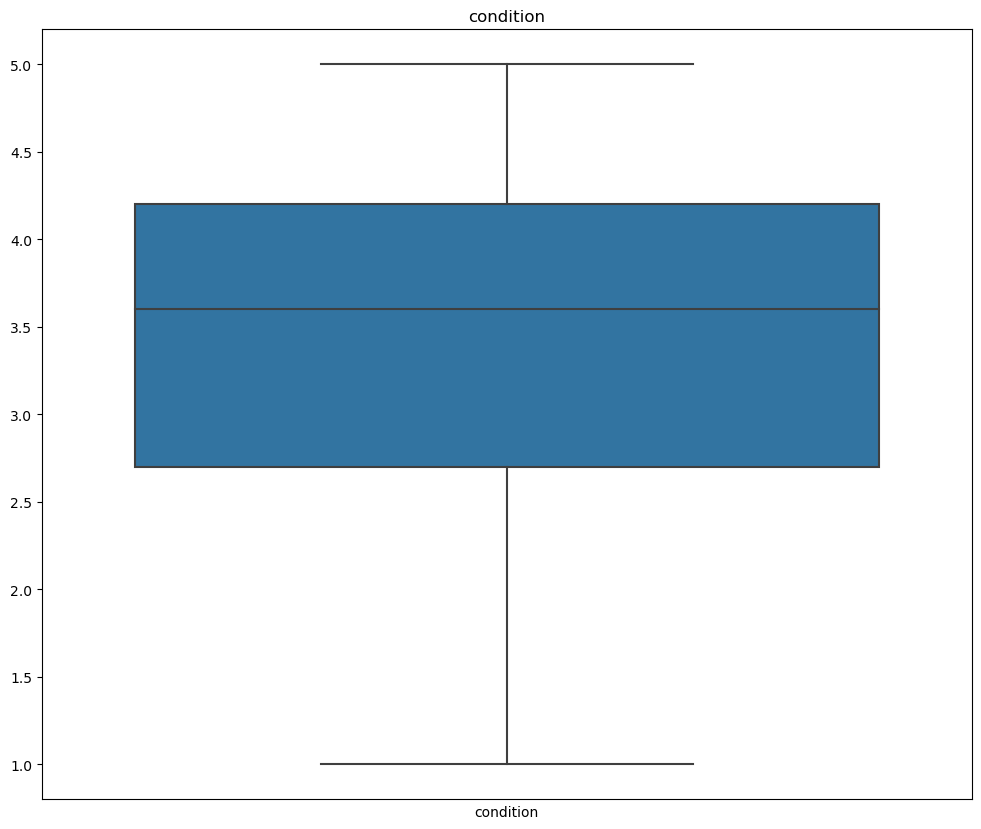

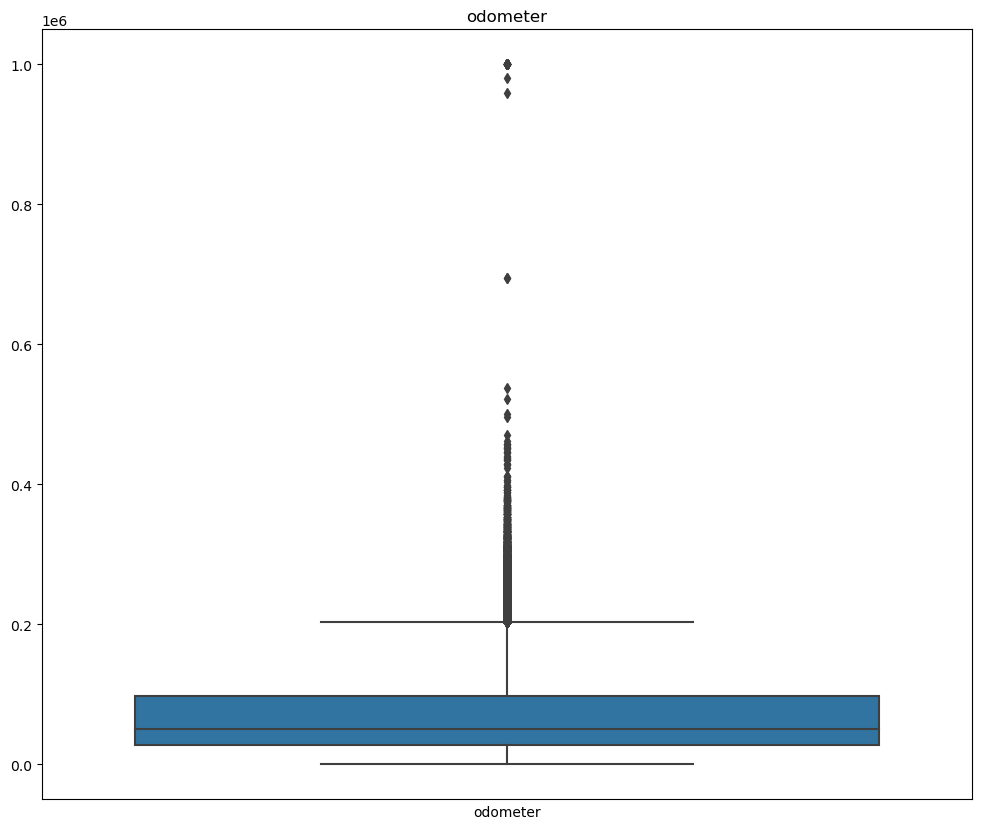

In [34]:
anomaly(df_train)

Проверяем на аномальные значения обучающую выборку:

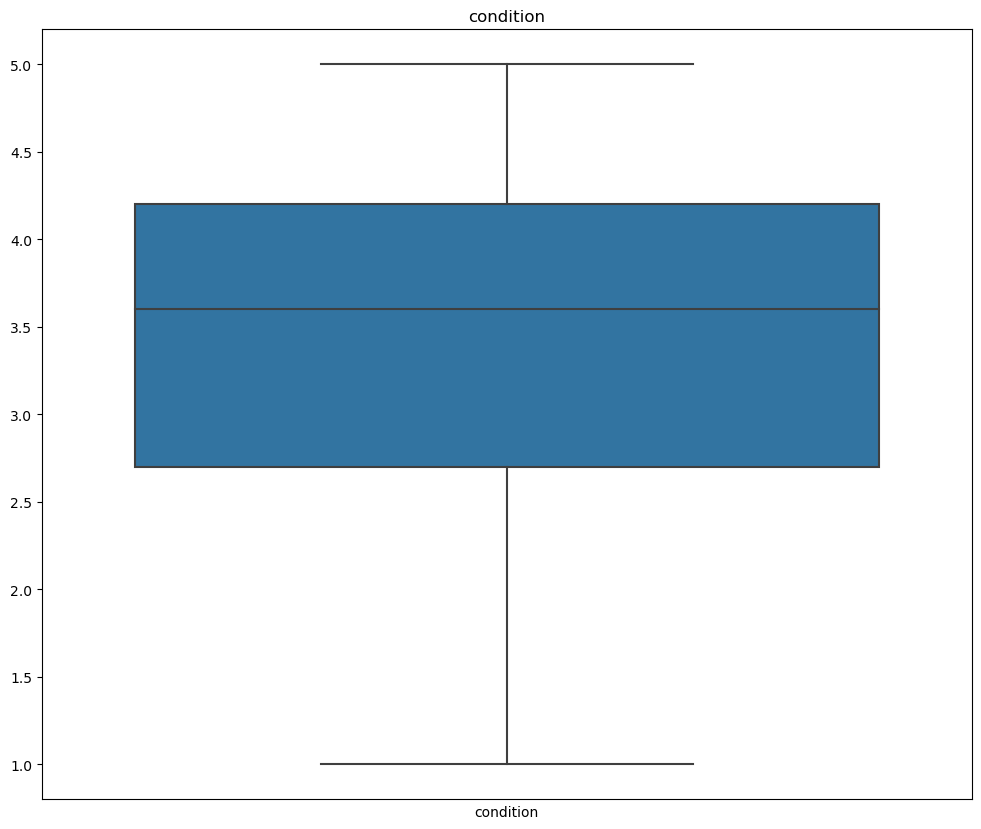

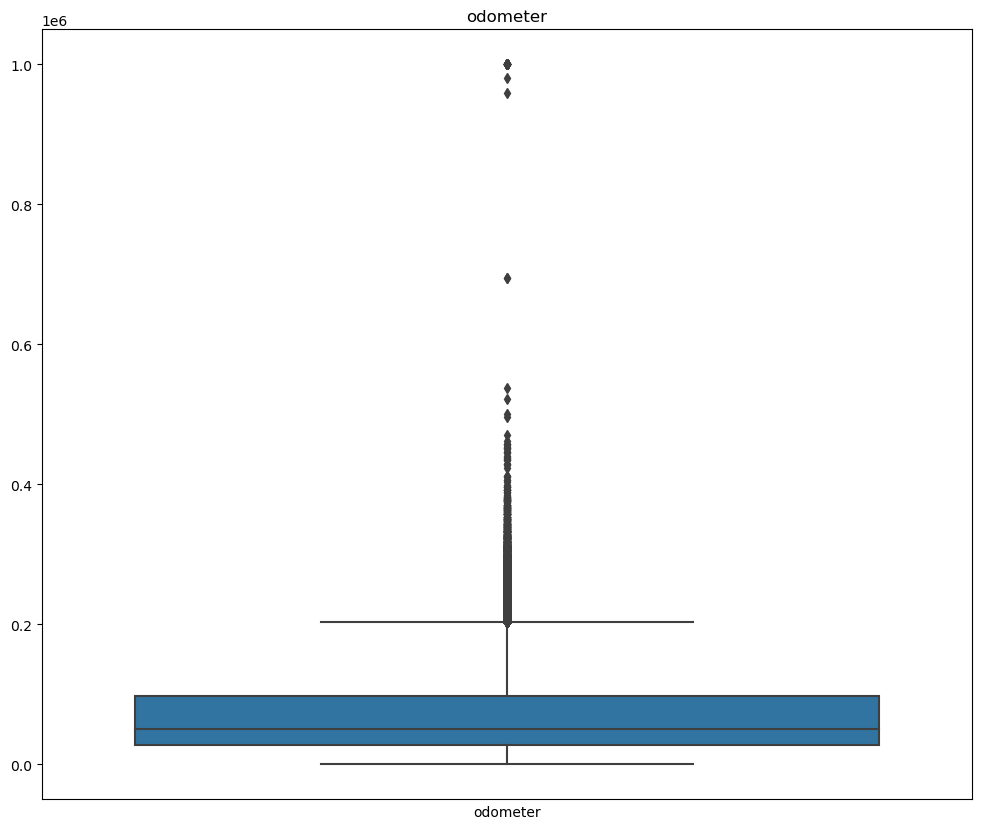

In [35]:
anomaly(df_test)

И в тестовой, и в обучающей выборках присутствует выбросы значений признаков "odometer" (пробег в милях) и "car_age" (возраст автомобиля) за третий квантиль. Максимальные значения признака "odometer" (пробег в милях) достигают 999999 миль.

Выводим минимальный и максимальный возраст автомобиля:

In [36]:
print('Минимальный возраст автомобиля: {}'.format(df_train['car_age'].min()))
print('Максимальный возраст автомобиля: {}'.format(df_train['car_age'].max()))

Минимальный возраст автомобиля: -1
Максимальный возраст автомобиля: 31


Датафрейм содержит данные за 1982-2015, поэтому значений выбросов признака "car_age" (возраст автомобиля) в большую сторону аномальными не являются: максимальный возраст автомобиля - 33 года. Минимальное значение признака "car_age" (возраст автомобиля) - минус один, что является аномалией. Заменяем отрицательные значения на на медианное значение возраста автомобиля в зависимости от пробега.

Определяем диапазоны, в которые попадают значения признака "odometer":

In [37]:
def odometer_range_func(df):
    df['odometer_range'] = pd.cut(df['odometer'], bins=np.linspace(0, df_train['odometer'].max(), 200))
    return df

In [38]:
df_train = odometer_range_func(df_train)
df_test = odometer_range_func(df_test)

In [39]:
def car_age_anomaly(df):
    for i in df['odometer_range'].unique():
        df.loc[(df['car_age'] == -1) & (df['odometer_range'] == i), 'car_age'] =\
        df_train.loc[df_train['odometer_range'] == i]['car_age'].median()
    return df

In [40]:
df_train = car_age_anomaly(df_train)
df_test = car_age_anomaly(df_test)

Заменяем пропуски значений признака "odometer" (пробег в милях), а так же пропуски значений признака "condition" на медианные значения тестовой выборки в зависимости от модели автомобиля:

In [41]:
def odometer_anomaly(df):
    for i in df_train['model'].unique():                     # проходим по списку моделей
        df_tmp = df_train.loc[df_train['model'] == i]        # создаем датафрейм с данными моделями
        for j in df_tmp['car_age'].unique():                 # проходим по списку возрастов автомобиля
            # заменяем пропуски 'odometer' на медиану
            df.loc[(df['model'] == i) & (df['odometer'].isna()), 'odometer'] =\
            df_train.loc[(df_train['model'] == i) & (df_train['car_age'] == j)]['odometer'].median()
            # заменяем пропуски 'condition' на медиану
            df.loc[(df['model'] == i) & (df['condition'].isna()), 'condition'] =\
            df_train.loc[(df_train['model'] == i) & (df_train['car_age'] == j)]['condition'].median()
    return df

In [42]:
df_train = odometer_anomaly(df_train)
df_test = odometer_anomaly(df_test)

Выводим общую информацию по обучающей и тестовой выборке:

In [43]:
intermediate_information(df_train)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate,week,car_age,odometer_range
28994,2013,chrysler,200,touring,sedan,automatic,1c3ccbbb8dn575524,ma,4.6,8694.0,gray,black,capital one auto finance,12700,2015-01-06 09:30:00+00:00,2,2.0,"(5025.121, 10050.241]"
64274,2006,chrysler,300,c,sedan,automatic,2c3la63h46h389006,ms,2.0,109189.0,white,gray,unknown,4000,2015-06-04 12:02:00+00:00,23,9.0,"(105527.533, 110552.653]"
274510,2003,dodge,ram,st,quad cab,automatic,1d7ha18n93s201478,tx,1.9,140173.0,gray,gray,credit acceptance corp/vrs/southfield,3800,2015-02-19 11:00:00+00:00,8,12.0,"(135678.256, 140703.377]"
155611,2012,nissan,rogue,s,suv,automatic,jn8as5mt2cw603912,ga,3.2,30208.0,black,gray,nissan infiniti lt,13100,2015-02-24 09:30:00+00:00,9,3.0,"(30150.724, 35175.844]"
124215,2012,volkswagen,jetta,se,sedan,automatic,3vwdx7aj5cm468950,pa,3.4,62447.0,red,beige,the hertz corporation,8600,2015-01-23 09:00:00+00:00,4,3.0,"(60301.447, 65326.568]"


<class 'pandas.core.frame.DataFrame'>
Index: 432193 entries, 0 to 440235
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   year            432193 non-null  int64              
 1   make            432193 non-null  object             
 2   model           432193 non-null  object             
 3   trim            432193 non-null  object             
 4   body            432193 non-null  object             
 5   transmission    432193 non-null  object             
 6   vin             432193 non-null  object             
 7   state           432193 non-null  object             
 8   condition       432193 non-null  float64            
 9   odometer        432193 non-null  float64            
 10  color           432193 non-null  object             
 11  interior        432193 non-null  object             
 12  seller          432193 non-null  object             
 13  sellingprice    432

In [44]:
intermediate_information(df_test)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,week,car_age,odometer_range
30257,2013,nissan,altima,2.5 s,coupe,automatic,1n4al2ep4dc153469,ga,3.7,56097.0,gray,black,the hertz corporation,2015-02-10 09:30:00+00:00,7,2.0,"(55276.327, 60301.447]"
90584,2014,nissan,nv,unknown,van,automatic,1n6bf0lyxen100980,pa,3.5,38828.0,white,gray,unknown,2015-02-18 09:30:00+00:00,8,1.0,"(35175.844, 40200.965]"
37119,2015,ford,taurus,limited,sedan,automatic,1fahp2f81fg104879,ne,4.0,17603.0,gray,black,unknown,2015-06-04 10:30:00+00:00,23,0.0,"(15075.362, 20100.482]"
86069,2010,chevrolet,silverado 1500,lt,crew cab,automatic,3gcrcse06ag218007,tx,2.9,111333.0,black,brown,unknown,2015-02-18 10:00:00+00:00,8,5.0,"(110552.653, 115577.774]"
37324,2005,ford,freestyle,se,wagon,automatic,1fmdk01165ga81292,nj,2.5,118248.0,gray,gray,wells fargo dealer services,2015-03-04 09:30:00+00:00,10,10.0,"(115577.774, 120602.894]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   year            110060 non-null  int64              
 1   make            110060 non-null  object             
 2   model           110060 non-null  object             
 3   trim            110060 non-null  object             
 4   body            110060 non-null  object             
 5   transmission    110060 non-null  object             
 6   vin             110060 non-null  object             
 7   state           110060 non-null  object             
 8   condition       110060 non-null  float64            
 9   odometer        110060 non-null  float64            
 10  color           110060 non-null  object             
 11  interior        110060 non-null  object             
 12  seller          110060 non-null  object             
 13  saledate      

1. Удалены неявные дубликаты признаков "make" и "model".
2. Пропуски признака "transmission" заменены на наиболее часто встречающееся в тренировочной выборке значения для каждой модели.
3. Из значений признаков "trim" (модификация), "seller" (продавец) удалены символы отличные от буквенных и числовых.
4. Добавлен признак "car_age" (возраст автомобиля на момент продажи).
5. Пропуски признаков "odometer" (пробег в милях) и "condition" (состояние автомобиля) заменены медианными значениями по обучающей выборке в зависимости от признаков "make" (производитель), "model" (модель) и "car_age" (возраст автомобиля).
6. Пропуски значений признаков "odometer" (пробег в милях) и "condition" (состояние) заменены на медианные значения тестовой выборки в зависимости от модели автомобиля.

## Исследовательский анализ данных
<a id="section_3"></a>

### Распределения значений признаков
<a id="section_3_1"></a>

Функция визуализации распределений:

In [45]:
def distribution(df_analysys):
    for i in df_analysys.columns:
        df = 100 * (df_analysys.groupby(i).size() / len(df_analysys))
        fig = plt.figure(figsize=(16,10))
        if list(df_analysys.columns) == analysys_bar_list:
            if (i == 'car_age') or (i == 'week'):
                ax = df.plot.bar()
            else:
                ax = df.sort_values().plot.bar()
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f')
            label = i + ', %'
        else:
            if i == 'condition':
                BINS=10
            else:
                BINS=30
            ax = sns.histplot(x=i, data=df_analysys, bins=BINS)
            label = i
        plt.title('Распределение признака {}'.format(i), fontsize=16)
        plt.ylabel(label)
        plt.show()

**Распределения дискретных значений**

Создаем список признаков, имеющих дискретные значения:

In [46]:
analysys_bar_list = ['make', 'body', 'transmission', 'state', 'color', 'interior', 'seller', 'car_age', 'week']

In [47]:
df_analysys = df_train.drop(['year', 'vin', 'saledate'], axis=1)
for column in df_analysys.columns:
    if (column in analysys_bar_list) & (column != 'week') & (column != 'car_age'):
        list_analysys = list(df_analysys[column].value_counts().reset_index().head(20)[column])
        df_analysys[column] = df_analysys.apply(lambda x: 'other' if x[column] not in list_analysys else x[column], axis=1)

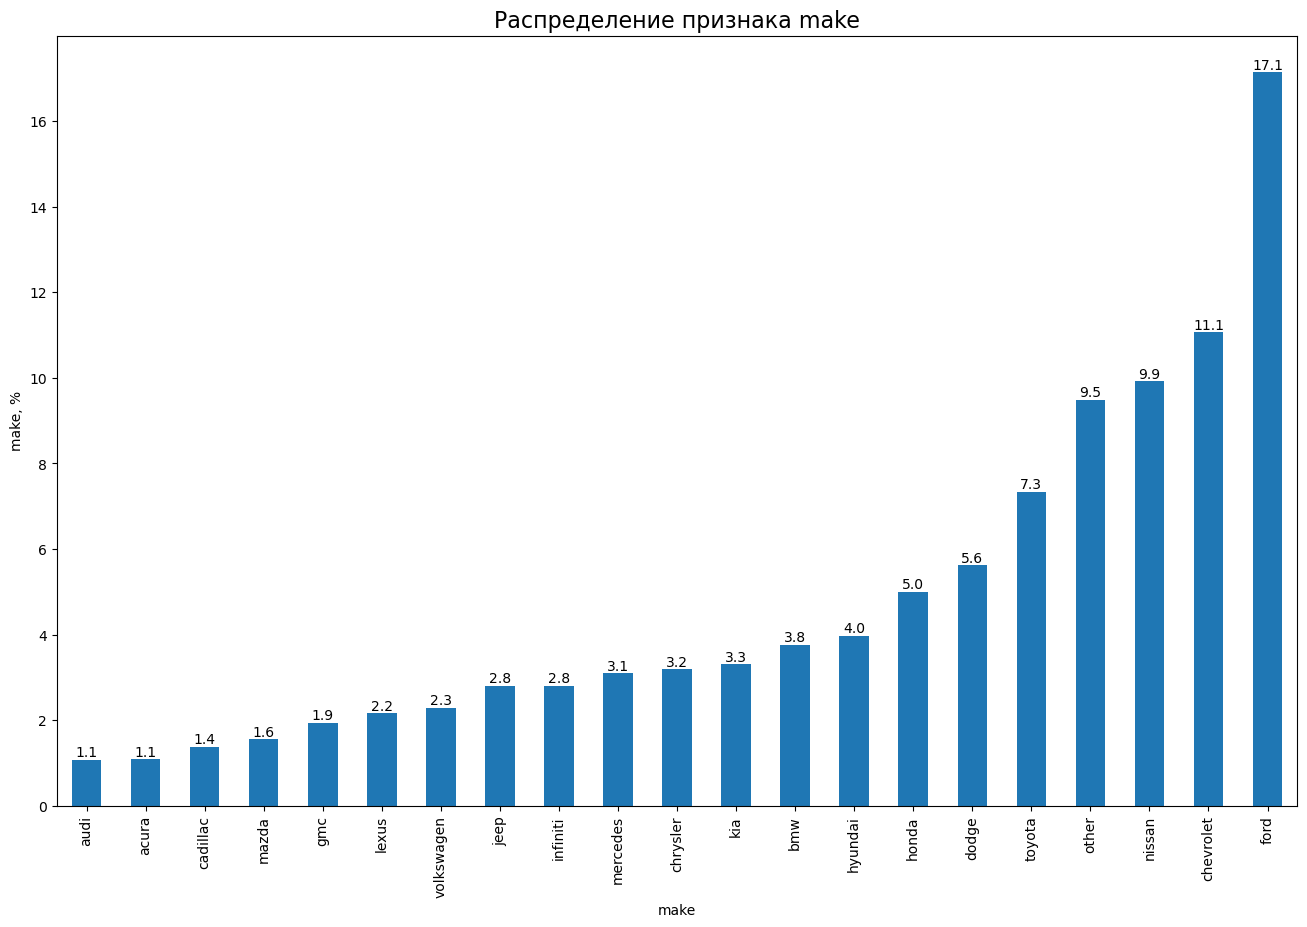

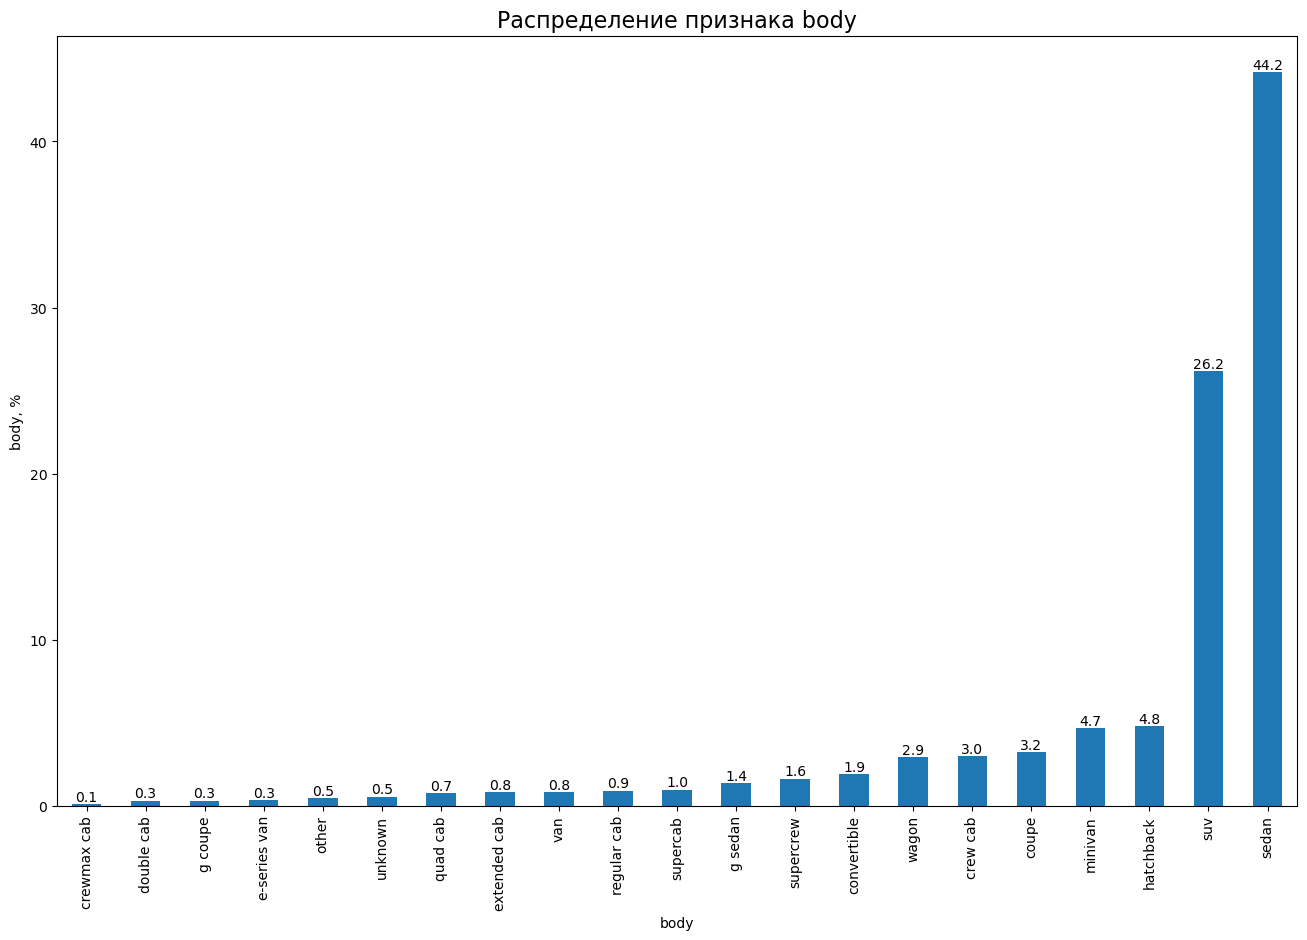

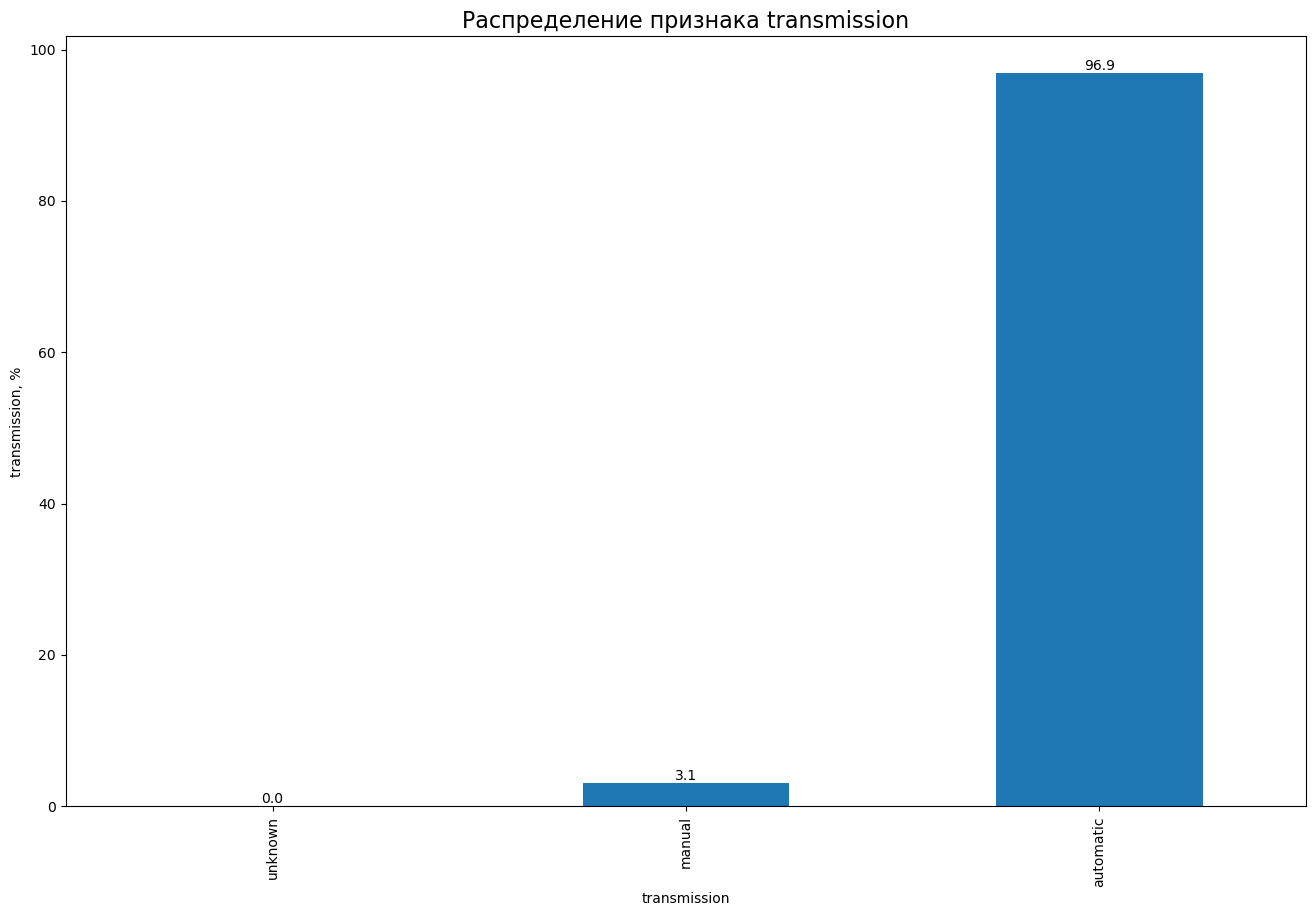

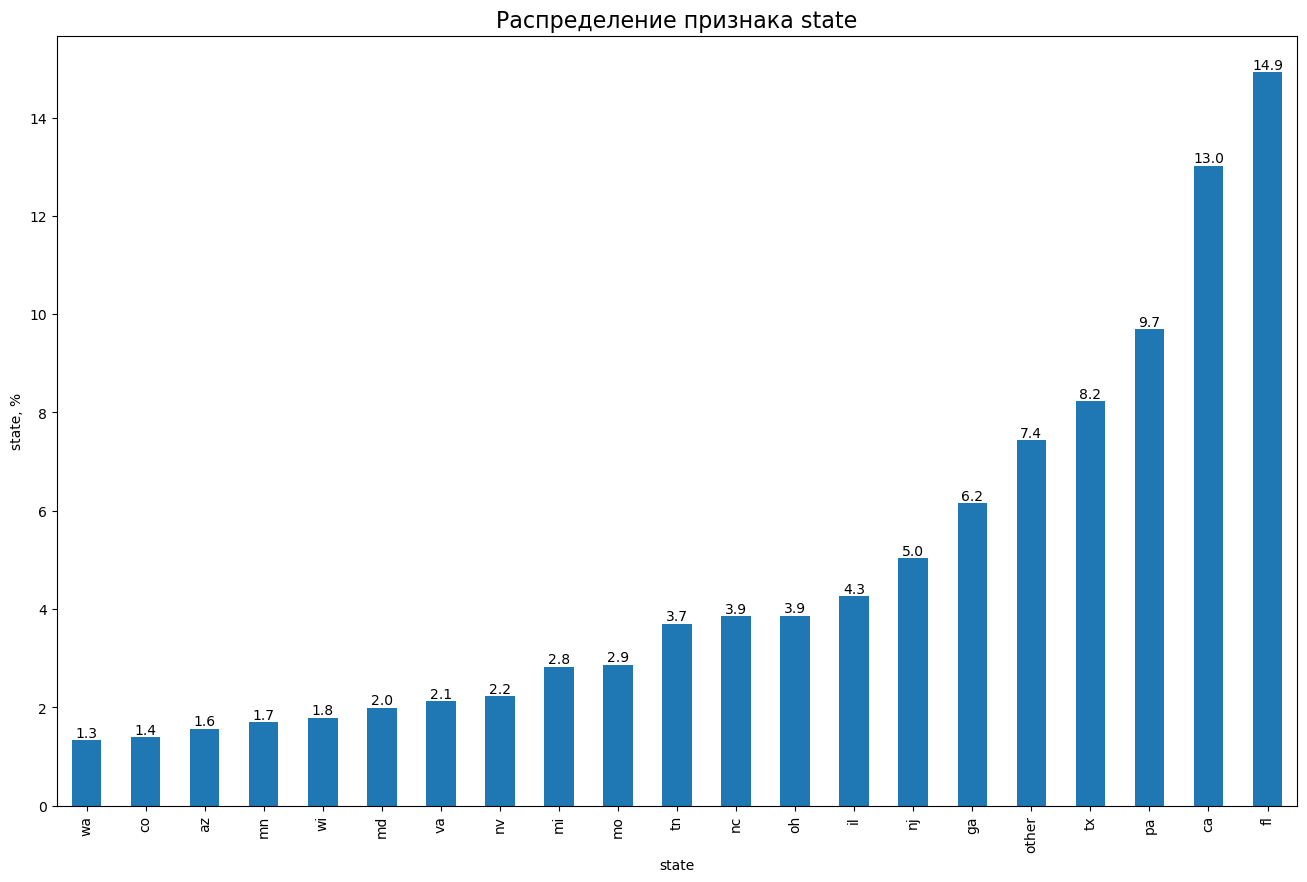

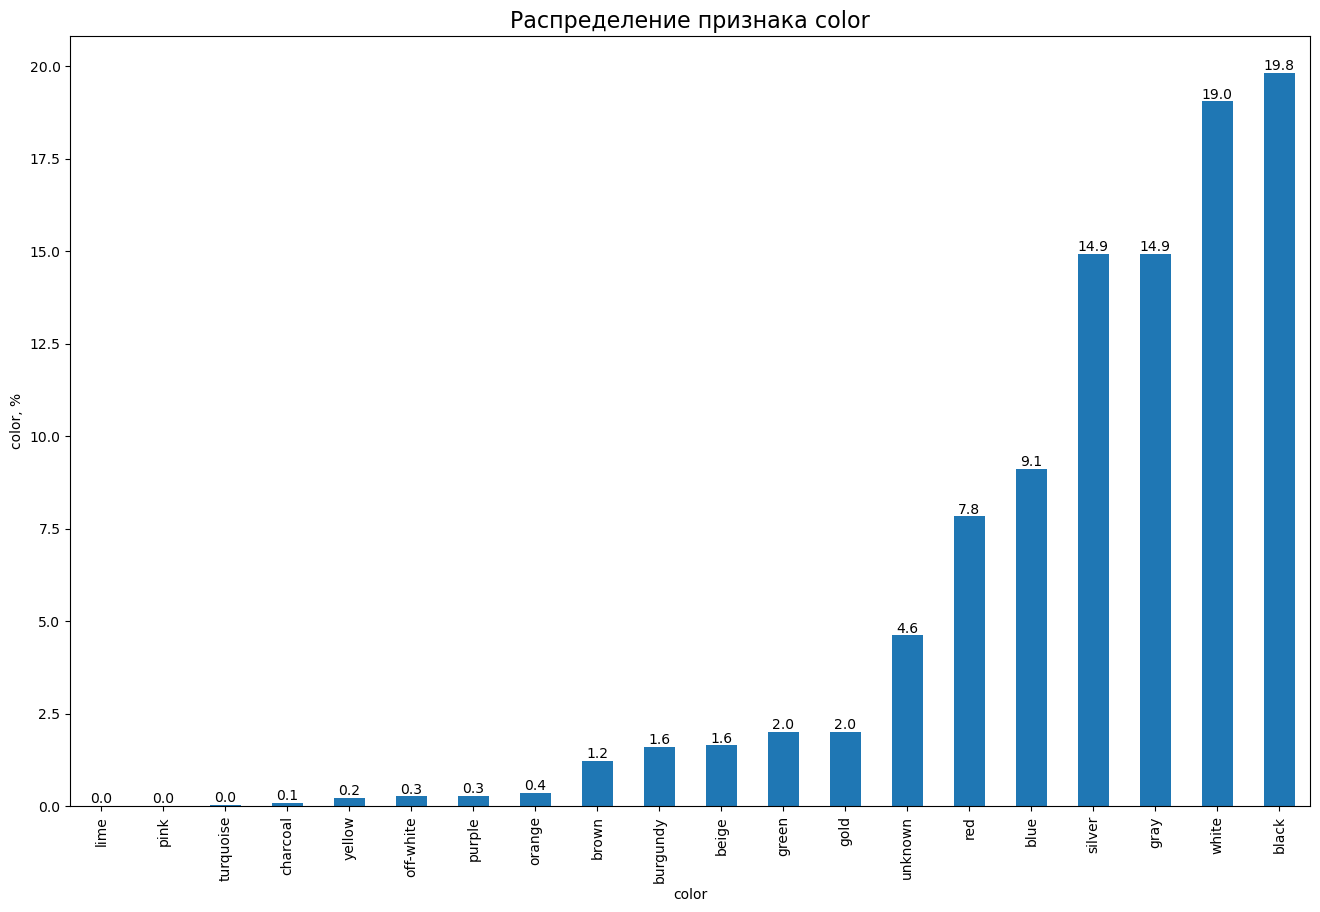

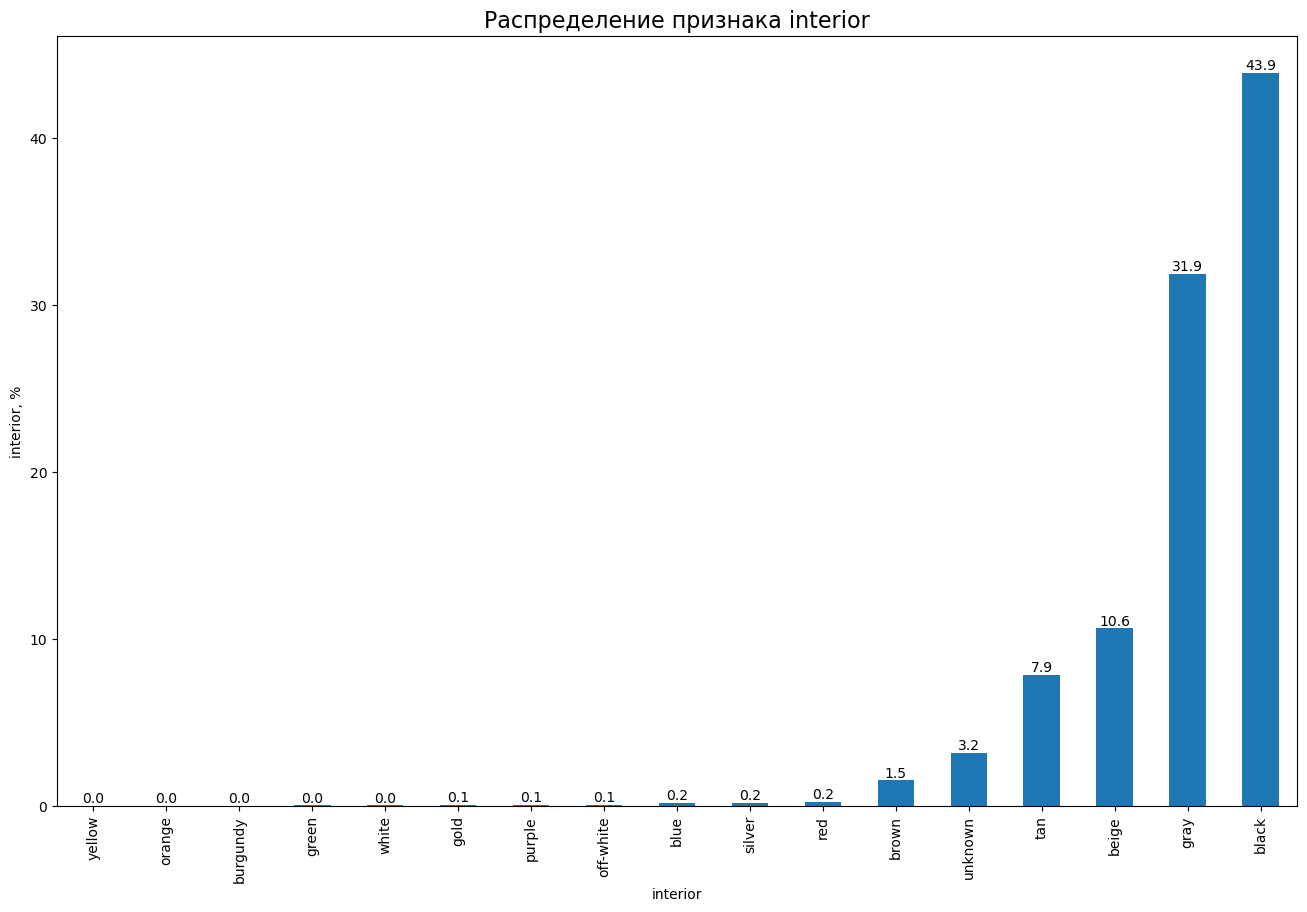

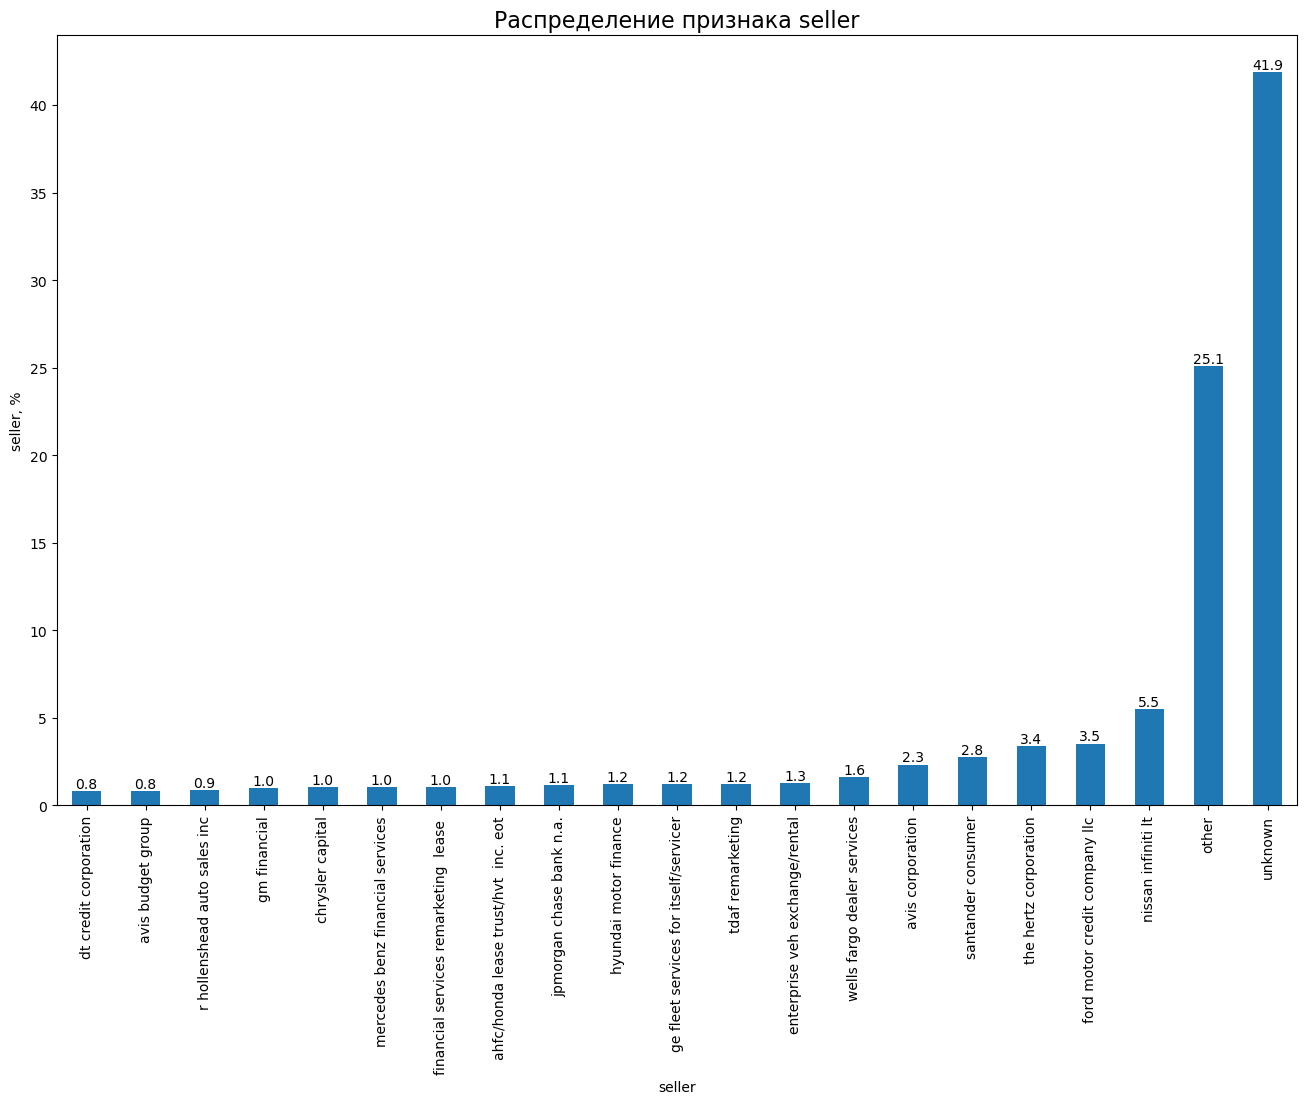

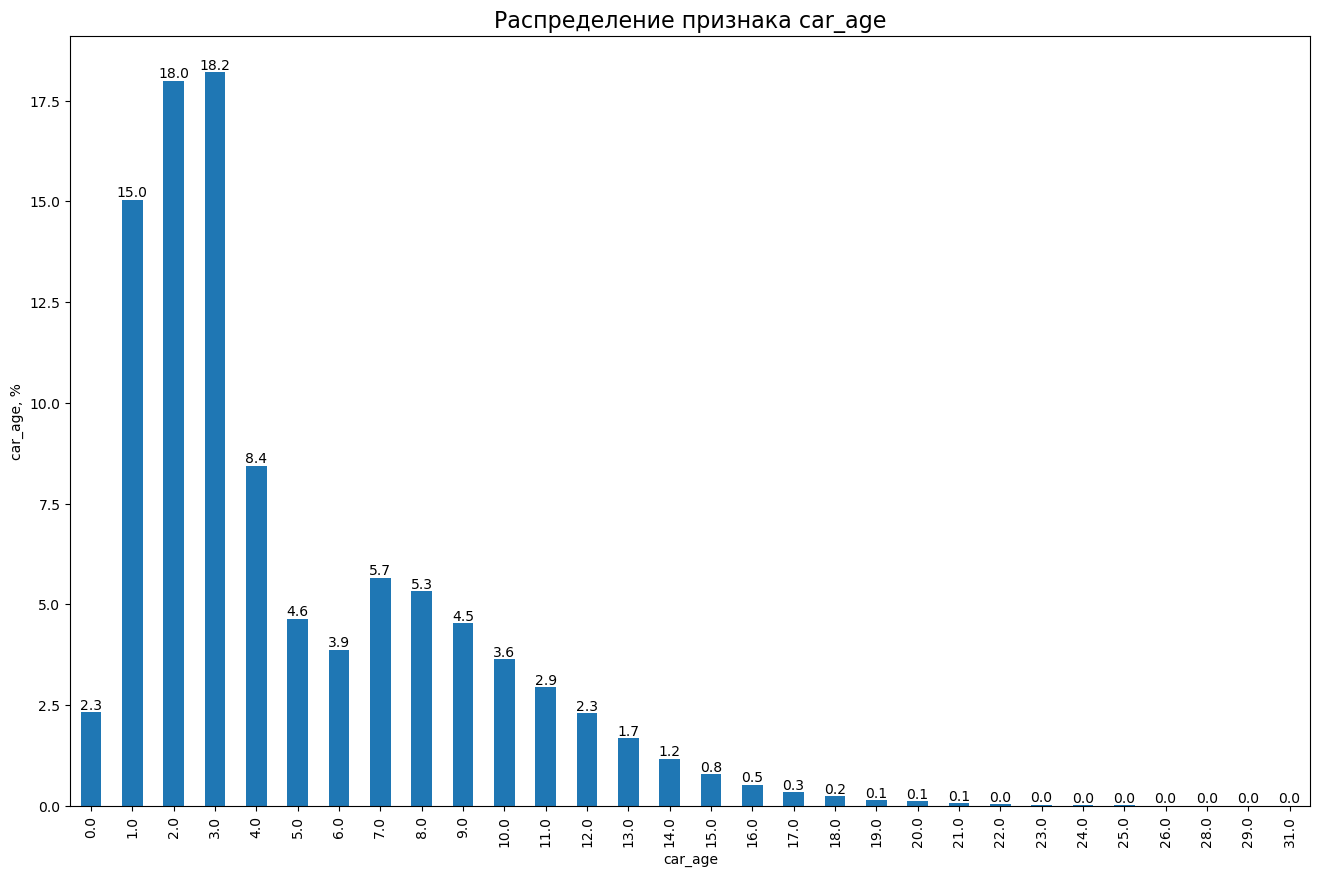

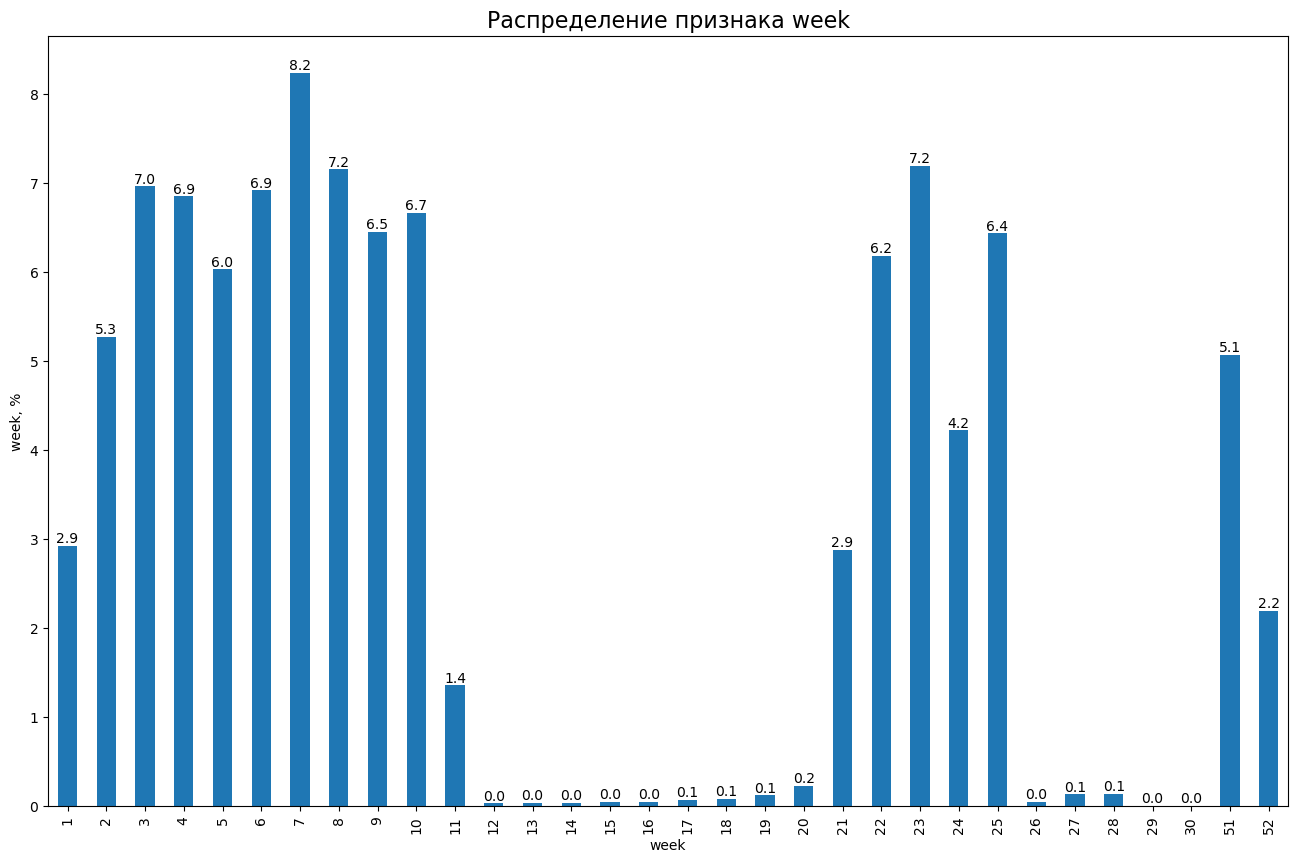

In [48]:
distribution(df_analysys[analysys_bar_list])

**Распределения непрерывных значений**

Создаем список признаков, имеющих непрерывные значения:

In [49]:
analysys_hist_list = ['condition', 'odometer']

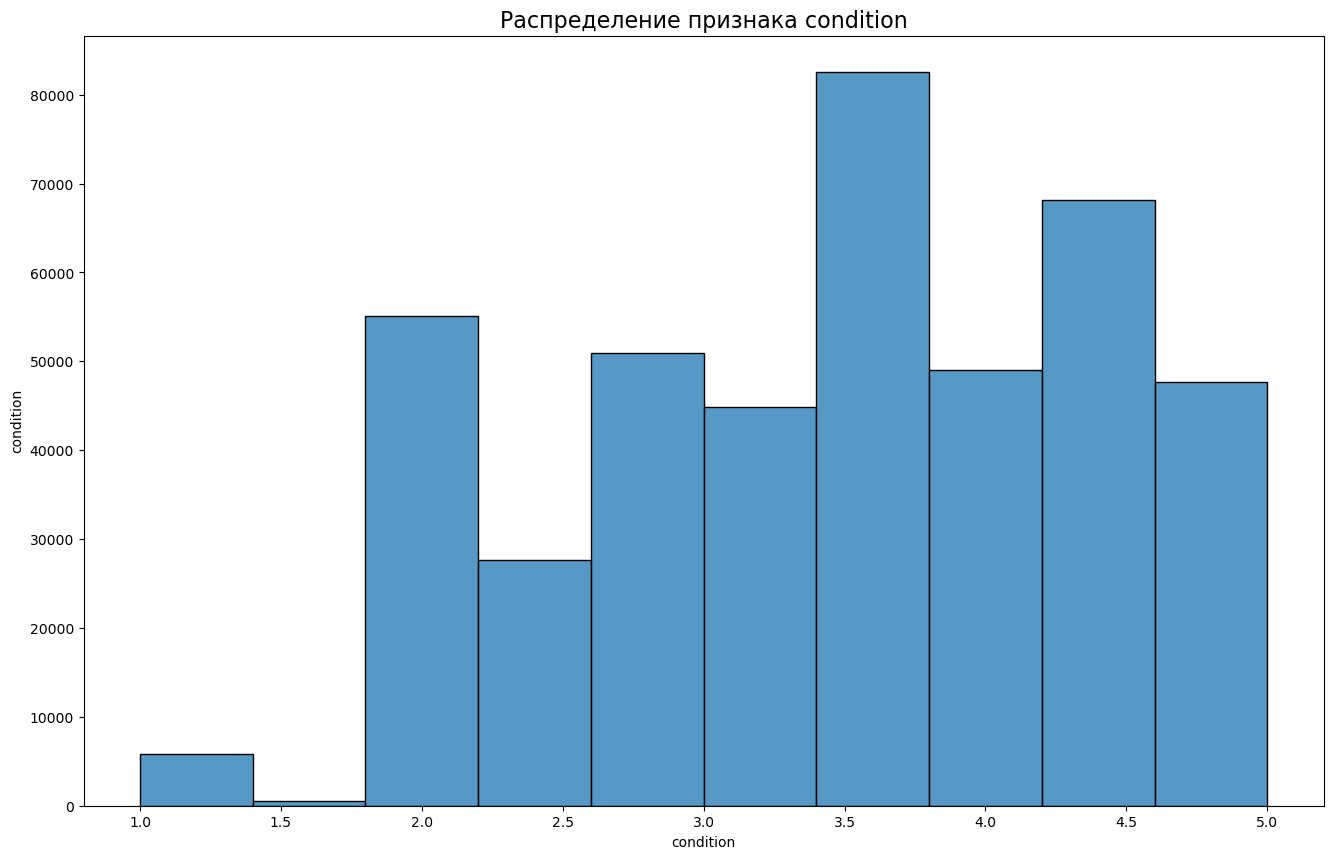

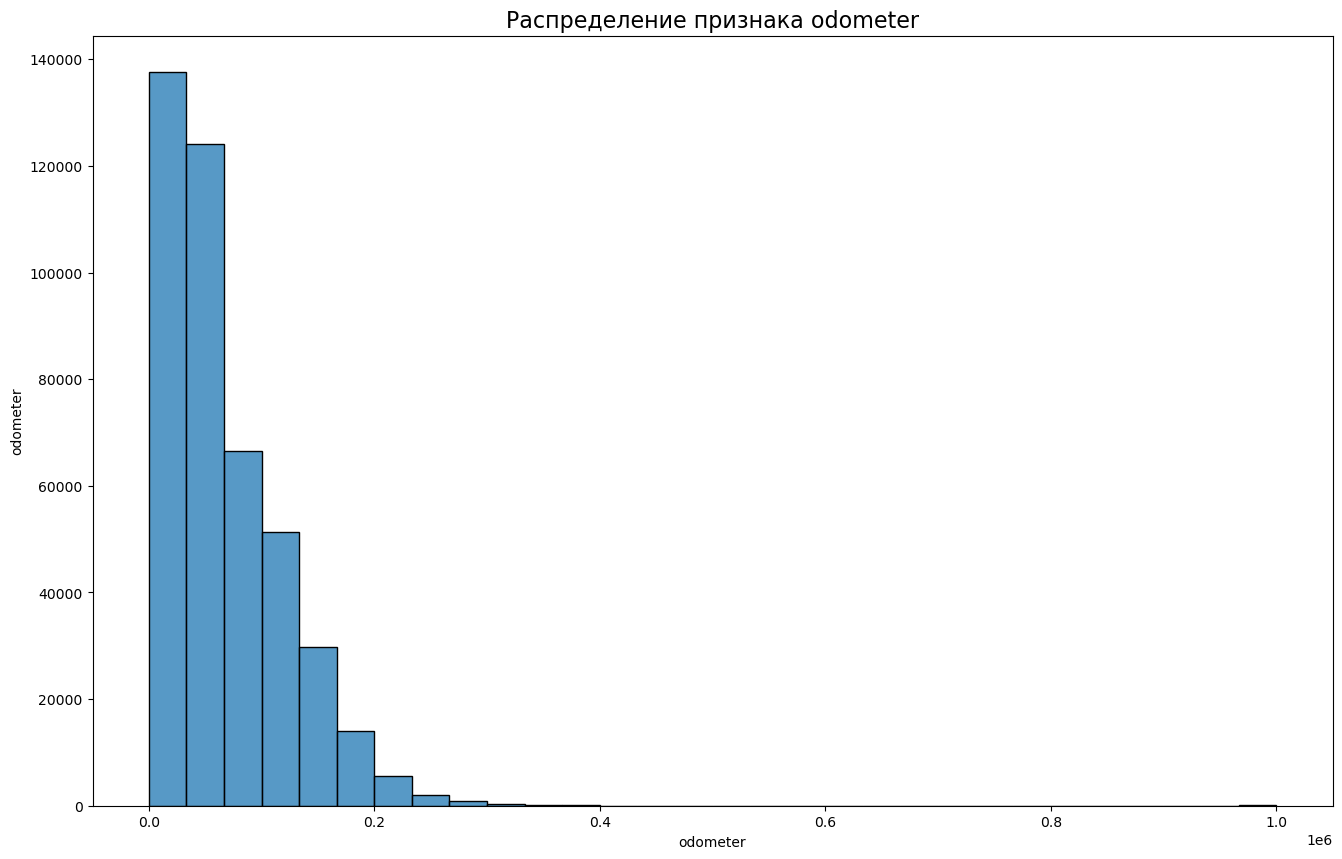

In [50]:
distribution(df_analysys[analysys_hist_list])

### Корреляция признаков
<a id="section_3_2"></a>

**Корреляция категориальных значений**

Создаем список категориальных признаков для анализа корреляции:

In [51]:
categorical_list_corr = ['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
                        'color', 'interior', 'week', 'seller']

Рассчитываем корреляцию категориальных признаков ($\phi_K$):

interval columns not set, guessing: ['year', 'week']
interval columns not set, guessing: ['year', 'week']
interval columns not set, guessing: ['year', 'week']


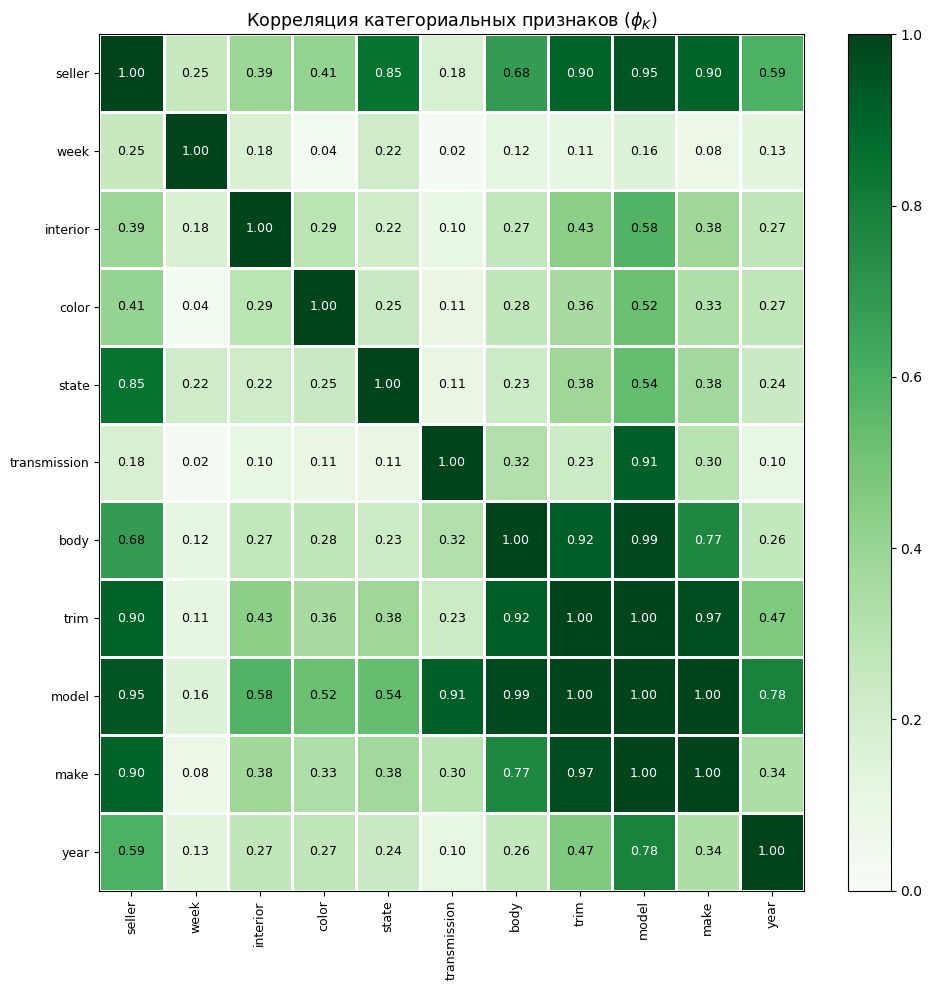

In [52]:
plot_correlation_matrix(df_train[categorical_list_corr].phik_matrix().values, 
                        x_labels=df_train[categorical_list_corr].phik_matrix().columns,   # значения x
                        y_labels=df_train[categorical_list_corr].phik_matrix().index,     # значения y
                        vmin=0, vmax=1,                                                 # минимальное и максимальное значения
                        color_map="Greens",                                             # цветовая палитра
                        title=r"Корреляция категориальных признаков ($\phi_K$)",        # заголовок
                        fontsize_factor=0.9,                                            # коэффициент размера шрифта
                        figsize=(10, 10)                                                # размер окна графика
                       )
plt.show()

**Корреляция числовых значений**

Создаем список числовых признаков для анализа корреляции:

In [53]:
numerical_list_corr = ['condition', 'odometer', 'car_age']

Рассчитываем корреляцию числовых значений (коэффициент Спирмена):

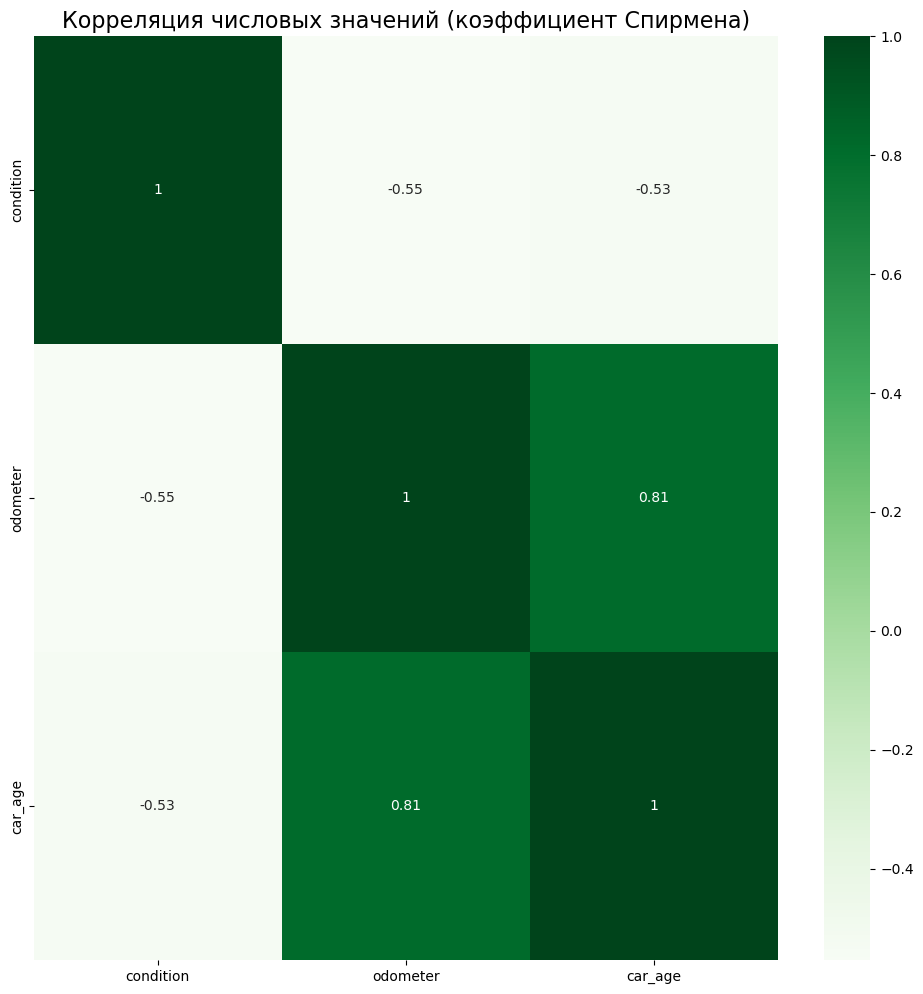

In [54]:
fig = plt.subplots(figsize=(12, 12))
sns.heatmap(df_train[numerical_list_corr].corr(method = 'spearman'), annot = True, cmap = 'Greens')
plt.title('Корреляция числовых значений (коэффициент Спирмена)', fontsize=16)
plt.show()

1. Самая продаваемая марка автомобиля - Ford (17,1%).  
2. Наиболее часто на вторичном рынке встречаются автомобили с типом кузова sedan (44,2%) и suv (26,2%).
3. Наиболее часто на вторичном рынке встречаются автомобили с типом КПП automatic (96,9%).
4. Наиболее часто на вторичном рынке встречаются автомобили с цветом кузова black (43,9%) и gray (31,9%).
5. Наиболее часто на вторичном рынке встречаются автомобили возрастом 1-3 года.
6. Наибольшие продажи приходятся на зимние месяцы и июнь.

<!-- **Вывод:**  
1. Самая продаваемая марка автомобиля - Ford (17,1%).
2. Наиболее часто на вторичном рынке встречаются автомобили с типом кузова sedan (44,2%) и suv (26,2%).
3. Наиболее часто на вторичном рынке встречаются автомобили с типом КПП automatic (96,9%).
4. Наиболее часто на вторичном рынке встречаются автомобили с цветом кузова black (43,9%) и gray (31,9%).
5. Наиболее часто на вторичном рынке встречаются автомобили возрастом 1-3 года.
6. Наибольшие продажи приходятся на зимние месяцы и июнь.
7. В выборке присутствуют коррелирующиеся признаки. Однако их удаление приводит к увеличению значения метрики качества, поэтому они оставлены. -->

## Обучение и оценка модели
<a id="section_4"></a>

### Подготовка данных
<a id="section_4_1"></a>

Из обучающей выборки выделяем входные и целевой признаки:

In [55]:
list_for_predict = ['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
                    'condition', 'odometer', 'color', 'interior', 'seller', 'car_age']
features = df_train[list_for_predict]
target = df_train['sellingprice']

Выделяем из обучающей выборки тестовую:

In [56]:
features_train, features_test_notebook, target_train, target_test_notebook = train_test_split(
    features, target, test_size=0.3, random_state=RS)
features_train = features_train.reset_index(drop=True)
features_test_notebook = features_test_notebook.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_test_notebook = target_test_notebook.reset_index(drop=True)
features_test = df_test[list_for_predict]
features_test = features_test.reset_index(drop=True)

### Обучение модели
<a id="section_4_2"></a>

Создаем списки категориальных и количественных признаков:

In [57]:
categorical_features = ['year', 'make', 'model', 'trim', 'body', 'transmission', 'state',
                        'color', 'interior', 'seller']
numerical_features = ['condition', 'odometer', 'car_age']

Создаем модель CatBoostRegressor:

In [58]:
model_cb = CatBoostRegressor(cat_features=categorical_features,
                          task_type="GPU",
                          loss_function = "RMSE",
                          eval_metric = "MAPE",
                          iterations = 2000,
                          verbose=0,
                          random_state=RS)

Задаем сетку подбора гиперпараметров:

In [59]:
params = {
    'depth' : intd(1, 10, False, 1),
}

Обучаем vодель CatBoostRegressor с подбором гиперпараметров через OptunaSearchCV:

In [60]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
model = OptunaSearchCV(model_cb, params, scoring='neg_mean_absolute_percentage_error', random_state=RS, cv=3)
start_time = timeit.default_timer()                                                            # начальное время обучения
model.fit(features_train, target_train)                                                        # обучаем модель
time_fit = timeit.default_timer() - start_time                                                 # время обучения

C:\Users\bond_\AppData\Local\Temp\ipykernel_19500\1290146550.py:2: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  model = OptunaSearchCV(model_cb, params, scoring='neg_mean_absolute_percentage_error', random_state=RS, cv=3)


Рассчитываем MAPE для тестовой выборки:

In [61]:
pred = model.predict(features_test_notebook)
mape_test_notebook = mean_absolute_percentage_error(target_test_notebook, pred)
print('Метрика MAPE на тестовой выборке: {:.3f}'.format(mape_test_notebook))
print('Гиперпараметры модели: {}'.format(model.best_params_))

Метрика MAPE на тестовой выборке: 0.152
Гиперпараметры модели: {'depth': 9}


### Оценка значимости признаков
<a id="section_4_3"></a>

Определяем веса признаков в стоимости автомобиля:

make         21.008500
model        18.787816
odometer     16.274252
body         10.678306
year          9.724914
car_age       6.603920
trim          6.212571
condition     5.734867
seller        1.168629
state         1.159901
dtype: float64


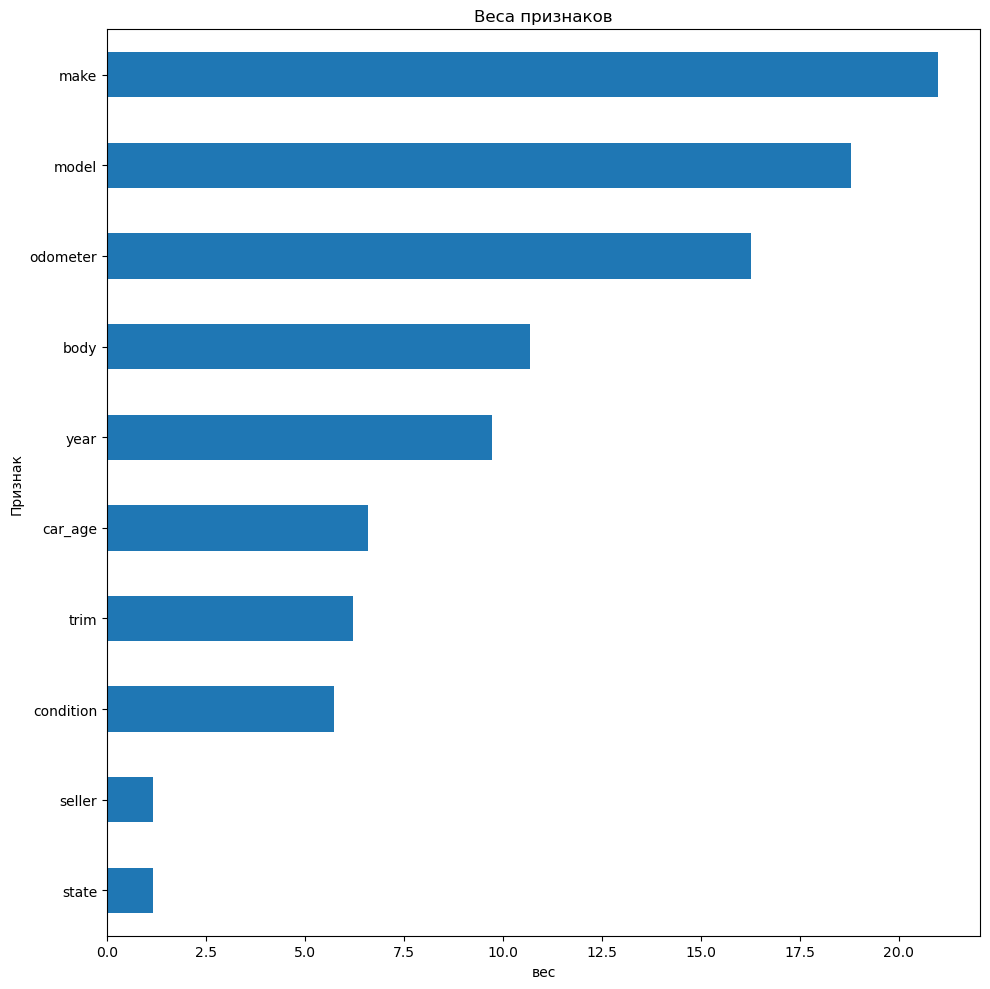

In [62]:
weight = (
    pd.Series(model.best_estimator_.get_feature_importance(),features_train.columns)
    .sort_values()
    .tail(10)
)
print(weight.sort_values(ascending=False))
plt.figure(figsize=(10, 10))
weight.plot(kind='barh')
plt.title('Веса признаков')
plt.xlabel('вес')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

### Предсказание на тестовой выборке
<a id="section_4_4"></a>

Оцениваем модель на тестовой выборке и сохраняем результат предсказания в файл csv:

In [63]:
predict_test = model.predict(features_test)
df_final_test = pd.DataFrame({'vin' : df_test['vin'],
                              'sellingprice' : predict_test})
df_final_test.to_csv('write_to_csv.csv', encoding='utf-8', index=False)

**Вывод:**
1. Используемая модель - CatBoostRegressor.  
2. При обучении модели использовались следующие признаки:  
- "year", "make", "model", "trim", "body", "transmission", "state", "color", "interior", "seller" - категориальные;  
- "condition", "odometer", "car_age" - числовые.  
- "sellingprice" - целевой.  
3. В качестве переменных рассматривались следующие параметры модели:  
- depth: от 1 до 10 с шагом 1.  
4. Параметры наилучшей модели:  
- 'depth': 9.  
5. MAPE тестовой выборки для лучшей модели: 0.152.
6. Наибольший вес в стоимости автомобиля имеют признаки:
- make;
- model;
- odometer.

## Общий вывод
<a id="section_5"></a>

**Загрузка данных и общая информация**  

1. В обучающей выборке 440236 строк и 15 признаков, в тестовой выборке 110060 строк и 14 признаков.
2. В полях make, model, trim, body, transmission, condition, odometer, color, interior присутствуют пропущенные значения.
2. Следующие признаки имеют тип int64:  
 - year;  
 - sellingprice.
 
 Следующие признаки имеют тип object:   
  - make;
  - model; 
  - trim; 
  - body; 
  - transmission; 
  - vin; 
  - state; 
  - color; 
  - interior; 
  - seller; 
  - saledate.   

 Следующие признаки имеют тип float64:  
  - condition;
  - odometer.
  

**Предобработка данных**  

1. Удалены неявные дубликаты признаков "make" и "model".
2. Пропуски признака "transmission" заменены на наиболее часто встречающееся в тренировочной выборке значения для каждой модели.
3. Из значений признаков "trim" (модификация), "seller" (продавец) удалены символы отличные от буквенных и числовых.
4. Добавлен признак "car_age" (возраст автомобиля на момент продажи).
5. Пропуски признаков "odometer" (пробег в милях) и "condition" (состояние автомобиля) заменены медианными значениями по обучающей выборке в зависимости от признаков "make" (производитель), "model" (модель) и "car_age" (возраст автомобиля).
6. Пропуски значений признаков "odometer" (пробег в милях) и "condition" (состояние) заменены на медианные значения тестовой выборки в зависимости от модели автомобиля.  


**Исследовательский анализ данных**  

1. Самая продаваемая марка автомобиля - Ford (17,1%).  
2. Наиболее часто на вторичном рынке встречаются автомобили с типом кузова sedan (44,2%) и suv (26,2%).
3. Наиболее часто на вторичном рынке встречаются автомобили с типом КПП automatic (96,9%).
4. Наиболее часто на вторичном рынке встречаются автомобили с цветом кузова black (43,9%) и gray (31,9%).
5. Наиболее часто на вторичном рынке встречаются автомобили возрастом 1-3 года.
6. Наибольшие продажи приходятся на зимние месяцы и июнь.


**Обучение и оценка модели**  

**Вывод:**
1. Используемая модель - CatBoostRegressor.  
2. При обучении модели использовались следующие признаки:  
- "year", "make", "model", "trim", "body", "transmission", "state", "color", "interior", "seller" - категориальные;  
- "condition", "odometer", "car_age" - числовые.  
- "sellingprice" - целевой.  
3. В качестве переменных рассматривались следующие параметры модели:  
- depth: от 1 до 10 с шагом 1.  
4. Параметры наилучшей модели:  
- 'depth': 9.  
5. MAPE тестовой выборки для лучшей модели: 0.152.
6. Наибольший вес в стоимости автомобиля имеют признаки:
- make;
- model;
- odometer.